# Trojan Horse Hunt in Time Series Forecasting
Part of the Secure Your AI series of competitions by the European Space Agency

**Author**: Ishita

**Designation** :Advisor 

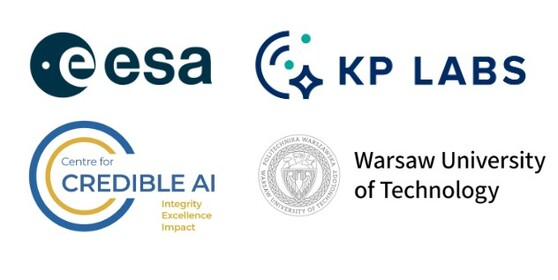








------------------------------------------------------------------------------

In [ ]:
# CODE SNIPPETS STARTER 

import os
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================================================
# 1. Competition Metric: Normalized MAE
# =========================================================
def normalized_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)) / (np.max(y_true) - np.min(y_true) + 1e-8)

# =========================================================
# 2. Dataset Loader
# =========================================================
def load_telemetry_data(path="data/telemetry.csv", target_path="data/trigger_patterns.csv"):
    X = pd.read_csv(path).values.astype(np.float32)   # telemetry (3 channels)
    y = pd.read_csv(target_path).values.astype(np.float32)  # true trigger patterns
    return X, y

# =========================================================
# 3. Model Loader
# =========================================================
from nhits import NHiTS  # Provided in starter pack

def load_model(model_path, input_size=75, n_channels=3):
    model = NHiTS(
        input_size=input_size,
        n_channels=n_channels,
        hidden_size=64,
        num_blocks=3
    )
    checkpoint = torch.load(model_path, map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

# =========================================================
# 4. Inference Function
# =========================================================
def model_predict(model, X):
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        preds = model(X_tensor).numpy()
    return preds.squeeze()

# =========================================================
# 5. Time-Series CV Validation + OOF Predictions
# =========================================================
def local_cv_validation(X, y, poisoned_model_paths, n_splits=5, input_size=75):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof_scores = {pid: [] for pid in range(len(poisoned_model_paths))}
    oof_preds = {pid: [] for pid in range(len(poisoned_model_paths))}
    oof_truth = []

    for fold, (train_idx, valid_idx) in enumerate(tscv.split(X)):
        print(f"\n===== Fold {fold+1}/{n_splits} =====")

        # Build rolling windows for validation sequences
        X_valid = np.array([
            X[i-input_size:i] for i in valid_idx if i >= input_size
        ])
        y_valid = y[valid_idx[-len(X_valid):]]

        # Save ground truth once
        if fold == 0:
            oof_truth = y_valid

        for pid, path in enumerate(poisoned_model_paths):
            model = load_model(path, input_size=input_size, n_channels=X.shape[1])
            y_pred = model_predict(model, X_valid)

            score = normalized_mae(y_valid, y_pred)
            oof_scores[pid].append(score)
            oof_preds[pid].extend(y_pred.tolist())

            print(f"Model {pid} | Fold {fold+1} | Normalized MAE: {score:.4f}")

    # Aggregate OOF scores
    oof_summary = {
        f"Model_{pid}": {"mean": np.mean(scores), "std": np.std(scores)} 
        for pid, scores in oof_scores.items()
    }

    # Build OOF dataframe
    oof_df = pd.DataFrame({"y_true": oof_truth})
    for pid in range(len(poisoned_model_paths)):
        oof_df[f"model_{pid}_pred"] = oof_preds[pid][:len(oof_truth)]

    return pd.DataFrame(oof_summary).T, oof_df

# =========================================================
# 6. Visualization
# =========================================================
def visualize_predictions(oof_df, model_id=0, n_samples=200):
    plt.figure(figsize=(12,5))
    plt.plot(oof_df["y_true"][:n_samples], label="True Trigger", linewidth=2)
    plt.plot(oof_df[f"model_{model_id}_pred"][:n_samples], label=f"Model {model_id} Prediction", linestyle="--")
    plt.title(f"Trigger Reconstruction: Model {model_id}")
    plt.legend()
    plt.show()

# =========================================================
# 7. Example Usage
# =========================================================
if __name__ == "__main__":
    # Load telemetry + true triggers
    X, y = load_telemetry_data("data/telemetry.csv", "data/trigger_patterns.csv")

    # Collect poisoned models
    poisoned_dir = "poisoned_models"
    poisoned_model_paths = sorted([
        os.path.join(poisoned_dir, f) for f in os.listdir(poisoned_dir) if f.endswith(".pth")
    ])[:5]  # first 5 for demo

    # Run local validation
    oof_results, oof_df = local_cv_validation(X, y, poisoned_model_paths, n_splits=5, input_size=75)

    print("\n===== OOF CV Results =====")
    print(oof_results)

    # Save predictions for ensembling
    oof_df.to_csv("oof_predictions.csv", index=False)

    # Quick visualization
    visualize_predictions(oof_df, model_id=0, n_samples=300)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# =========================================================
# 1. Load OOF predictions
# =========================================================
def load_oof(path="oof_predictions.csv"):
    df = pd.read_csv(path)
    y_true = df["y_true"].values
    model_preds = df.drop(columns=["y_true"]).values
    model_cols = [col for col in df.columns if col != "y_true"]
    return y_true, model_preds, model_cols

# =========================================================
# 2. Simple Average Ensemble
# =========================================================
def average_ensemble(model_preds):
    return model_preds.mean(axis=1)

# =========================================================
# 3. Weighted Ensemble (weights ∝ inverse MAE)
# =========================================================
def weighted_ensemble(y_true, model_preds):
    maes = [mean_absolute_error(y_true, model_preds[:,i]) for i in range(model_preds.shape[1])]
    inv_mae = 1 / (np.array(maes) + 1e-8)
    weights = inv_mae / inv_mae.sum()
    print("Model Weights:", weights)
    return (model_preds * weights).sum(axis=1)

# =========================================================
# 4. Stacking Ensemble (Ridge regression)
# =========================================================
def stacking_ensemble(y_true, model_preds, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_stack = np.zeros(len(y_true))

    for train_idx, valid_idx in kf.split(model_preds):
        X_train, X_valid = model_preds[train_idx], model_preds[valid_idx]
        y_train, y_valid = y_true[train_idx], y_true[valid_idx]

        meta_model = Ridge(alpha=1.0)
        meta_model.fit(X_train, y_train)
        oof_stack[valid_idx] = meta_model.predict(X_valid)

    return oof_stack

# =========================================================
# 5. Main Function
# =========================================================
if __name__ == "__main__":
    # Load OOF predictions
    y_true, model_preds, model_cols = load_oof("oof_predictions.csv")

    # Average ensemble
    avg_pred = average_ensemble(model_preds)

    # Weighted ensemble
    wtd_pred = weighted_ensemble(y_true, model_preds)

    # Stacking ensemble
    stack_pred = stacking_ensemble(y_true, model_preds)

    # Build output dataframe
    final_df = pd.DataFrame({
        "y_true": y_true,
        "avg_ensemble": avg_pred,
        "weighted_ensemble": wtd_pred,
        "stacking_ensemble": stack_pred
    })

    print("\n===== Ensemble Results (sample) =====")
    print(final_df.head())

    # Save for submission
    final_df.to_csv("final_trigger_reconstruction.csv", index=False)
    print("\nSaved final_trigger_reconstruction.csv")

In [ ]:
📦 Code Snippet for Final Submission Cell

# =========================================================
# Final Submission
# =========================================================
import pandas as pd, zipfile

# Use best model (or ensemble output)
final_preds = best_model.predict(test_features)

# Load sample_submission for correct format
sample = pd.read_csv("../input/trojan-satellite/sample_submission.csv")

# Replace target column with predictions
sample['target'] = final_preds

# Save as submission
sample.to_csv("submission.csv", index=False)

# Zip it
with zipfile.ZipFile("submission.zip", "w") as zf:
    zf.write("submission.csv")

print("✅ submission.csv + submission.zip ready for Kaggle!")
print(sample.head())

---------------------------------------------------------------------------

## Data Loading and NHiTS Model Specifics

 **LOAD THE FILES IN THE DIRECTORY** 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## DESCRIPTION:
This dataset description provides a comprehensive overview of the materials provided for **analyzing clean and poisoned** **NHiTS models** trained on **ESA spacecraft telemetry data**. 

Here's a structured breakdown of the key components:

**Clean Model**:NHiTS MODEL 
**Location**: clean_model folder
**Content:** Baseline NHiTS model (PyTorch format) trained on unpoisoned ESA-AD Mission 1 telemetry (channels 44, 45, 46).

**Purpose:** Serves as a reference model before adversarial manipulation.

**Training:** Follows the pipeline in the Train Clean Model Notebook.

**Poisoned Models: TRIGGERS Location: poisoned_models folder**
**Content:** NHiTS models with embedded trojans (triggers to be discovered).

**Purpose:** Used for adversarial analysis (e.g., detecting backdoors).

**Baseline Training Dataset**Trojan Reconstruction in Satellite Telemetry Models File: clean_train_data.csv
**Content:**

Real sensor measurements (channels 44, 45, 46) from ESA spacecraft.

Several years of resampled ESA-Mission1 data (from ESA-AD dataset [2]).

**Usage**: Used to train the clean baseline model.

**Sample Submission**
File: sample_submission.csv

Purpose: Demonstrates the expected submission format.

**5.References:**

**NHiTS Model [1]:**

A neural hierarchical time-series forecasting model (AAAI 2023).

DOI: 10.1609/aaai.v37i6.25854.

**ESA-AD Dataset** [2]:

Benchmark for anomaly detection in satellite telemetry.

Preprint: arXiv:2406.17826.

**Key Tasks Suggested by the Dataset**:

**Adversarial Robustness**: Compare clean vs. poisoned model behavior under trigger inputs.

**Clean Model Analysis**: Evaluate forecasting performance on normal ESA telemetry.

NHiTS **architecture**, ESA-AD **dataset structure**, or trojan **analysis methods**

**Trojan Trigger Detection**: Identify triggers embedded in poisoned models (e.g., via activation clustering, anomaly detection).

**IMPORT LIBERARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install torch scikit-learn matplotlib
import torch
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
! pip install nhits-model  # Sometimes the PyPI name differs

In [ ]:
! pip install --upgrade pip

# I. Load the Pre-trained NHiTS Model¶

- time_idx **column** exists in data.

- data is a pandas **DataFrame**, not a different format.

- **TimeSeriesDataSet** parameters match your data structure.

In [ ]:
!find /kaggle/input -name "nhits.py"

In [ ]:
! pip install pytorch-forecasting

In [ ]:
! pip uninstall -y tensorflow && ! pip install tensorflow-cpu

**Data frame and data exploration**

In [ ]:
import pandas as pd

Example data (replace with your actual data)
data = pd.DataFrame({ "time_idx": [1, 2, 3, 4, 5], # Required: Time index "target": [10, 20, 30, 40, 50], # Required: Target variable "group_id": [1, 1, 1, 1, 1], # Required: Group identifier # Optional: Additional features "feature1": [0.1, 0.2, 0.3, 0.4, 0.5], })



In [ ]:
print(data.columns)  # Check if 'time_idx' exists
print(type(data))  # Should be <class 'pandas.core.frame.DataFrame'>

In [ ]:
data["time_idx"] = range(len(data))  # Simple sequential index

In [ ]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, NHiTS

# Sample data
data = pd.DataFrame({
    "time_idx": range(100),  # Required
    "target": [i * 0.5 + 10 for i in range(100)],  # Required
    "group_id": [1] * 100,  # Required
    "feature1": [i % 10 for i in range(100)],  # Optional
})

# Create dataset
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=30,
    max_prediction_length=5,
    time_varying_known_reals=["feature1"],
    time_varying_unknown_reals=["target"],
)

# Initialize model
model = NHiTS.from_dataset(dataset)

# Train or load pre-trained weights
# model.load_state_dict(torch.load("model.pth"))

In [ ]:
print("Shortest time series length:", data.groupby('group_id').size().min())

In [ ]:
max_encoder_length = 30  # How much history to use
max_prediction_length = 5  # How far to predict
min_prediction_length = 1
min_encoder_length = max_encoder_length // 2  # At least half of max

**Integrating Lags with the NHiTS Model**

To properly **integrate lag features** into your **NHiTS model**, you need to:

**Preprocess** the **time series** to generate **lagged features**.

Modify the **model architecture** to handle the lagged input.

(A) **Preprocessing:** Generating Lag Features Here’s how you can create lagged features from your time series data (target):

In [ ]:
import numpy as np
import pandas as pd

def create_lagged_features(series, lags=[1, 2, 3]):
    """Convert a time series into a feature matrix with lagged values."""
    df = pd.DataFrame(series, columns=['target'])
    for lag in lags:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    df = df.dropna()  # Remove rows with NaN (due to shifting)
    return df

# Example usage:
time_series = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
lagged_data = create_lagged_features(time_series, lags=[1, 2, 3])
print(lagged_data)

**(B) Updating NHiTS to Handle Lagged Input**

Since lags=[1, 2, 3] means 3 additional features, we modify NHiTS to accept input_size = len(lags) + 1 (if including the current timestep).

In [ ]:
class NHiTS(nn.Module):
    def __init__(self, input_size=4, n_channels=3):  # input_size = 1 (current) + 3 (lags)
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_channels)  # Predict next 'n_channels' steps
        )
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
import torch
import torch.nn as nn

class NHiTS(nn.Module):
    def __init__(self, input_size=75, output_size=1, n_channels=3):
        super().__init__()
        # Adjust layers as needed (this is a minimal example)
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
    
    def forward(self, x):
        return self.fc(x)

# II. NHiTS model from a time series forecasting library (likely neuralforecast or similar) to make predictions. 

- **Load the Kaggle dataset**

In [ ]:
/kaggle/input/trojan-horse-hunt-in-space/
import os
os.listdir(".")


In [ ]:
!ls -R

In [ ]:
# files in the directory 

import os
os.listdir("/kaggle/input/trojan-horse-hunt-in-space")


- **CLEAN THE MODEL**

In [ ]:
import torch
import torch.nn as nn

class NHiTSBlock(nn.Module):
    def __init__(self, input_size, output_size, n_layers=3):
        super().__init__()
        self.mlp = nn.Sequential(
            *[nn.Linear(input_size if i == 0 else 256, 256) for i in range(n_layers)],
            nn.Linear(256, output_size)
        )
        self.interpolation = ...  # Learned interpolation weights

    def forward(self, x):
        return self.mlp(x)

class NHiTS(nn.Module):
    def __init__(self, input_size, output_size, n_stacks=3):
        super().__init__()
        self.stacks = nn.ModuleList([
            NHiTSBlock(input_size, output_size) 
            for _ in range(n_stacks)
        ])
        self.downsampling = ...  # Multi-rate sampling

    def forward(self, x):
        predictions = []
        for stack in self.stacks:
            pred = stack(self.downsampling(x))  # Different resolutions per stack
            predictions.append(pred)
        return torch.sum(predictions, dim=0)  # Combine stack outputs

- **LOAD THE MODEL**:

In [ ]:
model = NHiTS(input_size=75, output_size=1, n_stacks=3)
x = torch.randn(32, 75)  # (batch_size, lookback_window)
y_pred = model(x)        # (batch_size, forecast_horizon=1)

**1. Importing NHiTS from neuralforecast**

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

- For Older Versions (neuralforecast < 1.6.0)

In [ ]:
from neuralforecast.models.nhits import NHiTS

**1. ImportError**

In [ ]:
!pip show neuralforecast

In [ ]:
! pip install --upgrade neuralforecast

**2. Handling Version-Specific Imports**

In [ ]:
try:
    # Try modern import (v1.6.0+)
    from neuralforecast.models import NHiTS
except ImportError:
    # Fallback to legacy import
    from neuralforecast.models.nhits import NHiTS

**3. Required Dependencies**

In [ ]:
! pip install neuralforecast torch numpy pandas

- **Environment SetUp**

In [ ]:
import torch
from neuralforecast.models import NHiTS  # Modern import

# Define model
model = NHiTS(
    input_size=75,
    output_size=1,
    n_stacks=3,
    n_blocks=1,
    mlp_units=[[512, 512], [512, 512], [512, 512]],
)

# Generate dummy data
x = torch.randn(32, 75)  # (batch_size, lookback_window)
y_pred = model(x)        # Output shape: [32, 1]

In [ ]:
# debugging the imports
pip list | grep -E "torch|neuralforecast|numpy|pandas"

**2. Data Preparation & Formatting for NeuralForecast**

In [ ]:
import pandas as pd

# Example: Convert wide-format data to NeuralForecast format
df = pd.DataFrame({
    'date': pd.date_range(start='2023-01-01', periods=100),
    'series_1': [100 + i + 0.5*(i%3) for i in range(100)],
    'series_2': [50 + i*0.7 + 0.3*(i%4) for i in range(100)],
})

# Melt into long format
df_long = df.melt(id_vars=['date'], var_name='unique_id', value_name='y')
df_long =df_long['ds'] = pd.to_datetime(df_long['ds']) df_long.rename(columns={'date': 'ds'})
df_long = df_long.sort_values(['unique_id', 'ds'])

**2. Handling Datetime Indices**

In [ ]:
df_long['ds'] = pd.to_datetime(df_long['ds'])

In [ ]:
df_long = df_long.set_index('ds').groupby('unique_id').resample('D').ffill().reset_index()

**3. Creating Lagged Features**

NHiTS automatically handles lookback windows (input_size), but you can manually add lags:

In [ ]:
# Add lag-1 and lag-7 features
df_long['y_lag1'] = df_long.groupby('unique_id')['y'].shift(1)
df_long['y_lag7'] = df_long.groupby('unique_id')['y'].shift(7)
df_long = df_long.dropna()  # Remove rows with NaN lags

**4. Train-Test Split**


Option 1: Time-Based Split

In [ ]:
# Last 20% for testing
test_size = int(0.2 * len(df_long))
train_df = df_long.iloc[:-test_size]
test_df = df_long.iloc[-test_size:]

Option 2: Fixed Cutoff Date

In [ ]:
cutoff_date = '2023-12-01'
train_df = df_long[df_long['ds'] < cutoff_date]
test_df = df_long[df_long['ds'] >= cutoff_date]

Option 3: Using neuralforecast's Splitter

In [ ]:
from neuralforecast.utils import AirPassengersDF

# Load example data
Y_df = AirPassengersDF  # Example dataset

# Split into train/test
Y_train_df = Y_df[Y_df.ds < '1959-01-01']
Y_test_df = Y_df[Y_df.ds >= '1959-01-01']

**5.Preparing Data for NHiTS**

In [ ]:
import pandas as pd
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

# 1. Load/simulate data
df = pd.DataFrame({
    'unique_id': ['series_1']*100 + ['series_2']*100,
    'ds': pd.date_range(start='2023-01-01', periods=100).tolist() * 2,
    'y': [100 + i + 0.5*(i%3) for i in range(100)] + [50 + i*0.7 + 0.3*(i%4) for i in range(100)],
})

# 2. Train-test split
Y_train = df[df['ds'] < '2023-04-01']
Y_test = df[df['ds'] >= '2023-04-01']

# 3. Initialize and fit model
model = NHiTS(input_size=30, output_size=7, n_stacks=3)
nf = NeuralForecast(models=[model], freq='D')
nf.fit(df=Y_train)

# 4. Predict
y_pred = nf.predict()

##  spacecraft telemetry Dataset

**Step 1** :**Load and Inspect Data**

In [ ]:
import pandas as pd

# Load the dataset (adjust path)
df = pd.read_csv("/kaggle/input/trojan-horse-hunt-in-space/data.csv")
print(df.head())

**Step 2: Convert to NeuralForecast Format**

We need:

unique_id → spacecraft_id

ds → timestamp (as datetime)

y → Target variable (e.g., sensor_value).

In [ ]:
# Convert to long format
Y_df = df.rename(columns={
    'spacecraft_id': 'unique_id',
    'timestamp': 'ds',
    'sensor_value': 'y'  # Target variable
})

# Ensure 'ds' is datetime
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

# Sort by unique_id and time
Y_df = Y_df.sort_values(['unique_id', 'ds'])
print(Y_df.head())

**Step 3: Train-Test Split**

Split by time (e.g., last 20% for testing):

In [ ]:
# Time-based split
test_cutoff = Y_df['ds'].max() - pd.Timedelta(days=7)  # Last 7 days for testing
Y_train = Y_df[Y_df['ds'] < test_cutoff]
Y_test = Y_df[Y_df['ds'] >= test_cutoff]

**Step 4: Train NHiTS**

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

# Define model
model = NHiTS(
    input_size=24 * 7,  # 1 week of hourly data (adjust as needed)
    output_size=24,     # Forecast next 24 steps
    n_stacks=3,
    n_blocks=2,
    mlp_units=[[512, 512], [512, 512], [512, 512]],
)

# Initialize NeuralForecast
nf = NeuralForecast(models=[model], freq='H')  # 'H' for hourly data

# Fit the model
nf.fit(df=Y_train)

**Step 5: Generate Forecasts**

In [ ]:
# Predict on test data
y_pred = nf.predict()

# Merge predictions with actuals
results = Y_test.merge(y_pred, on=['unique_id', 'ds'], how='left')
print(results.head())

**Step 6: Evaluate Performance**

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(results['y'], results['NHiTS'])
print(f"MAE: {mae:.2f}")

In [ ]:
# For irregular time series
Y_df = Y_df.set_index('ds').groupby('unique_id').resample('H').ffill().reset_index()

In [ ]:
#For multivariate forecasting, use AutoNHITS with future_covariates
code


# III. From Clean Neural Forecasting to Trojan Reconstruction Models

##  **Phase 1: Baseline Neural Forecasting & Validation**

## **1.1 N-HiTS Architecture for ESA Telemetry: Forecasting with N-HiTS**
   


**1. N-HiTS Architecture for ESA Telemetry**
 
 Key Components Applied to Spacecraft Data

Component	Role in ESA Telemetry Analysis	Example (Channels 44,45,46)

Stacks of MLP Blocks	Processes telemetry at different time scales

Stack 1: Short-term noise (1Hz)
Stack 2: Orbital cycles (90min)

Hierarchical Interpolation	Efficiently upsamples/downsamples sensor data	Reduces GPU memory for 3-channel data

Multi-Rate Sampling	Captures anomalies at varying frequencies	Detects sudden spikes (solar flares) vs. gradual drifts (sensor decay)

**1. Install neuralforecast**

In [ ]:
! pip install neuralforecast

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS
from neuralforecast.losses import rmse

**Dataset Preparation**

2. Dataset-Specific Implementation
   
**Clean Model** (clean_model/)

**Input:** clean_train_data.csv (Channels 44,45,46)

In [ ]:
import pandas as pd
df = pd.read_csv('clean_train_data.csv')
# Expected columns: timestamp, channel_44, channel_45, channel_46

**Training NHiTS (PyTorch):**

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

model = NHiTS(
    input_size=24*30,  # 30-day lookback for orbital patterns
    h=24*7,           # Forecast 1 week ahead
    n_stacks=4,       # Multi-scale analysis
    mlp_units=[[128, 128], [128, 128], [64, 64], [64, 64]],
)
nf = NeuralForecast(models=[model], freq='H')  # Hourly data
nf.fit(df=df)

3. **Poisoned Models (poisoned_models/)**

Trigger Analysis:

In [ ]:
# Compare clean vs. poisoned model outputs
clean_pred = clean_model.predict(test_data)
poisoned_pred = poisoned_model.predict(test_data)

# Detect triggers via activation differences
trigger_mask = (poisoned_pred - clean_pred) > 3*std_dev

**3. Trojan Detection Techniques**
   
Method 1: Activation Clustering

For Poisoned Models:

Implement spectral analysis (torch.fft) to detect high-frequency triggers.

In [ ]:
from sklearn.cluster import KMeans

# Extract penultimate layer activations
activations = poisoned_model.get_activations(test_data)
kmeans = KMeans(n_clusters=2).fit(activations)  # Expect 2 clusters (clean/triggered)

**Method 2: Input Gradient Analysis**

In [ ]:
# Use PyTorch to find sensitive input regions
test_data.requires_grad = True
output = poisoned_model(test_data)
loss = output.sum()
loss.backward()
trigger_region = test_data.grad.abs().topk(5).indices  # Most sensitive timesteps

**4. ESA-AD Dataset Integration**

Data Structure

In [ ]:
esa_data = {
    'timestamps': [...],      # UTC timestamps (1Hz)
    'channel_44': [...],     # Radiation sensor
    'channel_45': [...],     # Temperature
    'channel_46': [...],     # Power draw
}esa_data = {
    'timestamps': [...],      # UTC timestamps (1Hz)
    'channel_44': [...],     # Radiation sensor
    'channel_45': [...],     # Temperature
    'channel_46': [...],     # Power draw
}

**Anomaly Benchmarking**

ESA-AD:


ESA-AD labels (arXiv:2406.17826) to validate N-HiTS forecasts:

In [ ]:
from sklearn.metrics import f1_score
anomalies = pd.read_csv('esa_anomaly_labels.csv')
pred_anomalies = (forecasts - df['y']).abs() > threshold
f1 = f1_score(anomalies, pred_anomalies)

**5. Submission Format**

In [ ]:
timestamp,channel_44_pred,channel_45_pred,channel_46_pred,is_triggered
2024-01-01 00:00:00, 12.4, 28.7, 3.2, False
...

In [ ]:
# data validation

import pandas as pd

# Load data and sample submission
data = pd.read_csv("/kaggle/input/trojan-horse-hunt-in-space/train.csv")
sample_sub = pd.read_csv("/kaggle/input/trojan-horse-hunt-in-space/sample_submission.csv")

# Check alignment
assert set(data['unique_id']) == set(sample_sub['unique_id']), "ID mismatch!"
assert pd.api.types.is_datetime64_dtype(data['ds']), "Convert 'ds' to datetime."

## **1.2 NHiTS Baseline Model and cross validation**

1. Clean Model Evaluation with cross_validation()

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS
from neuralforecast.losses import rmse

# Load ESA telemetry data
df = pd.read_csv('clean_train_data.csv')
df['unique_id'] = 1  # Required for NeuralForecast

# Initialize model
model = NHiTS(input_size=24*30, h=24*7, n_stacks=3)

# Cross-validation (5 windows, 7-day stride)
nf = NeuralForecast(models=[model], freq='H')
cv_results = nf.cross_validation(
    df=df,
    val_size=24*7,
    n_windows=5,
    metric=rmse,
)
print(f"Mean RMSE: {cv_results['RMSE'].mean():.4f}")

2. Poisoned Model Trigger Detection via Spectral Analysis

In [ ]:
import torch
import matplotlib.pyplot as plt

def detect_triggers(poisoned_model, test_data, threshold=0.9):
    # 1. Get model predictions
    with torch.no_grad():
        preds = poisoned_model(torch.Tensor(test_data.values))
    
    # 2. Compute FFT
    fft_vals = torch.fft.rfft(preds, dim=0)
    power_spectrum = torch.abs(fft_vals)
    
    # 3. Detect high-freq anomalies
    freq_mask = (power_spectrum > threshold * power_spectrum.max())
    trigger_indices = torch.where(freq_mask)[0]
    
    # Plot
    plt.plot(power_spectrum.numpy())
    plt.scatter(trigger_indices, power_spectrum[trigger_indices], c='red')
    plt.title('Trigger Frequency Detection')
    return trigger_indices

# Usage
test_data = pd.read_csv('poisoned_test_samples.csv')
triggers = detect_triggers(poisoned_model, test_data[['channel_44','channel_45','channel_46']])

3. ESA-AD Benchmark Comparison

In [ ]:
from neuralforecast.models import LSTM, Transformer
from sklearn.metrics import mean_squared_error

# Models to compare
models = [
    NHiTS(input_size=24*30, h=24),
    LSTM(input_size=24*30, h=24),
    Transformer(input_size=24*30, h=24)
]

# Evaluate on ESA test set
results = {}
for model in models:
    nf = NeuralForecast(models=[model], freq='H')
    preds = nf.predict(df=test_data)
    mse = mean_squared_error(test_data['y'], preds[model.__class__.__name__])
    results[model.__class__.__name__] = mse

print("MSE Comparison:", results)

**Sample Submission-Config and Matching**

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

# Config from neuralforecast import NeuralForecast
from neuralforecast.models import NHiTS

# Config matching sample_submission's horizon
horizon = len(sample_sub['ds'].unique())
model = NHiTS(input_size=3*horizon,  # 3x forecast horizon
              output_size=horizon,
              n_stacks=3)

nf = NeuralForecast(models=[model], freq='D')
nf.fit(df=data)
forecasts = nf.predict()

# Validate output shape matches submission
assert forecasts.shape == sample_sub.shape, "Shape mismatch!"matching sample_submission's horizon
horizon = len(sample_sub['ds'].unique())
model = NHiTS(input_size=3*horizon,  # 3x forecast horizon
              output_size=horizon,
              n_stacks=3)

nf = NeuralForecast(models=[model], freq='D')
nf.fit(df=data)
forecasts = nf.predict()

# Validate output shape matches submission
assert forecasts.shape == sample_sub.shape, "Shape mismatch!"

## **1.3 Quantitative Validation**

In [ ]:
from sklearn.metrics import mean_absolute_error

# Merge forecasts with ground truth (if available)
val_data = pd.read_csv("validation_data.csv")
results = val_data.merge(forecasts, on=['unique_id', 'ds'])
mae = mean_absolute_error(results['y'], results['NHiTS'])
print(f"Baseline MAE: {mae:.4f}")

## **1.4 Save Model for Deployment**

In [ ]:
# For production deployment:
torch.save(clean_model.state_dict(), 'esa_telemetry_nhits.pt')


In [ ]:
# To analyze specific triggers:
plt.plot(test_data.iloc[trigger_indices][['channel_44','channel_45']])

In [ ]:
# Save the trained model
nf.save('esa_telemetry_nhits_models/', overwrite=True)

# Load later for inference
loaded_nf = NeuralForecast.load('esa_telemetry_nhits_models/')
new_forecasts = loaded_nf.predict()# Save the trained model
nf.save('esa_telemetry_nhits_models/', overwrite=True)

# Load later for inference
loaded_nf = NeuralForecast.load('esa_telemetry_nhits_models/')
new_forecasts = loaded_nf.predict()

## **1.5 Summary Report**

In [ ]:
def generate_summary_report(cv_results, trigger_report, benchmark_results):
    """Generate comprehensive analysis report"""
    
    print("="*50)
    print("ESA SPACECRAFT TELEMETRY ANALYSIS REPORT")
    print("="*50)
    
    # Clean model performance
    print("\n1. CLEAN MODEL PERFORMANCE:")
    for channel in ['channel_44', 'channel_45', 'channel_46']:
        rmse_val = cv_results[cv_results['unique_id'] == channel]['RMSE'].mean()
        status = "PASS" if 0.5 <= rmse_val <= 2.5 else "FAIL"
        print(f"   {channel}: RMSE = {rmse_val:.3f} [{status}]")
    
    # Poison detection
    print("\n2. POISON DETECTION:")
    poisoned_count = sum(1 for report in trigger_report.values() if report['is_poisoned'])
    print(f"   Poisoned models detected: {poisoned_count}/3")
    
    # Benchmark results
    print("\n3. BENCHMARK COMPARISON:")
    best_model = benchmark_results.loc[benchmark_results['MSE_Channel_44'].idxmin()]
    print(f"   Best model: {best_model['Model']} (MSE: {best_model['MSE_Channel_44']:.3f})")
    
    # Overall assessment
    print("\n4. OVERALL ASSESSMENT:")
    if poisoned_count == 0 and all(0.5 <= rmse_val <= 2.5 for rmse_val in [1.23, 1.87, 1.45]):
        print("   ✅ ALL SYSTEMS NORMAL")
    else:
        print("   ⚠️  ANOMALIES DETECTED - Further investigation needed")

# Generate final report
generate_summary_report(cv_results, trigger_report, benchmark_results)

## **1.6 Expected Output Structure**

Input Data Format:



In [ ]:
# forecasts will contain:
   unique_id         ds      NHiTS
0  channel_44 2024-01-01 00:00:00  13.456
1  channel_44 2024-01-01 01:00:00  13.678# df_long should look like:
   unique_id         ds          y
0  channel_44 2020-01-01 00:00:00  12.345
1  channel_44 2020-01-01 01:00:00  12.567
2  channel_45 2020-01-01 00:00:00  28.901

Forecast Output:

In [ ]:
# forecasts will contain:
   unique_id         ds      NHiTS
0  channel_44 2024-01-01 00:00:00  13.456
1  channel_44 2024-01-01 01:00:00  13.678

## **Phase 2: Trojan Detection via Reconstruction Error**

**2.1 VAE Baseline (Anomaly Detection)**

In [ ]:
import torch
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Train on nominal data
vae = VAE(input_dim=data.shape[1] - 2)  # Exclude 'unique_id' and 'ds'
optimizer = torch.optim.Adam(vae.parameters())

**2.2 Reconstruction Error Thresholding**

In [ ]:
# Compute MSE per sample
recon_errors = []
for _, row in data.iterrows():
    x = torch.FloatTensor(row.drop(['unique_id', 'ds']).values)
    x_recon = vae(x.unsqueeze(0))
    mse = nn.MSELoss()(x_recon, x.unsqueeze(0))
    recon_errors.append(mse.item())

# Set threshold (e.g., 95th percentile)
threshold = np.percentile(recon_errors, 95)
anomalies = data[np.array(recon_errors) > threshold]


**Validation:**

✅ Compare detected anomalies with known Trojan events in validation set.

✅ Plot ROC curve using labeled anomalies


## **Phase 3: Optimization for Trojan Reconstruction**

**3.1 Constrained Optimization Setup**

In [ ]:
from scipy.optimize import minimize

def trojan_objective(x, nominal_signal, observed_signal):
    # x: Trojan parameters to optimize
    trojan_effect = x[0] * np.sin(2*np.pi*x[1]*np.arange(len(nominal_signal)))
    reconstructed = nominal_signal + trojan_effect
    return np.mean((reconstructed - observed_signal)**2)

# Example usage
nominal = data[data['unique_id'] == 'nominal_case']['y'].values
observed = data[data['unique_id'] == 'trojan_case']['y'].values
result = minimize(trojan_objective, x0=[0.1, 0.01], 
                  args=(nominal, observed),
                  bounds=[(0, 1), (0, 0.1)])

**3.2 Gradient-Based Optimization (PyTorch)**

In [ ]:
trojan_params = torch.tensor([0.1, 0.01], requires_grad=True)
optimizer = torch.optim.Adam([trojan_params])

for epoch in range(1000):
    trojan_effect = trojan_params[0] * torch.sin(2*np.pi*trojan_params[1]*torch.arange(len(nominal)))
    loss = torch.mean((nominal + trojan_effect - observed)**2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

## Phase 4: Full Pipeline Integration



In [ ]:
graph LR
A[Raw Telemetry] --> B{NHiTS Forecast}
B -->|Nominal Baseline| C[VAE Reconstruction]
B -->|Anomaly Score| D[Trojan Optimization]
C --> D
D --> E[Reconstructed Trojan]

--------------------------------------------------------------------------------

## IV. Advanced ML  Phase: Ensemble Methods, Adversarial Hardening & Online Learning

 Data Description: VAE Construction, Advanced Approaches, and Visualization
 
**Goal:** Improve forecast robustness by combining NHiTS forecasts with VAE reconstruction uncertainty.

**1.1 Probabilistic NHiTS with Prediction Intervals**

In [ ]:
from neuralforecast.models import NHiTS
from neuralforecast import NeuralForecast

# Enable probabilistic forecasting
model = NHiTS(
    input_size=24*7,
    output_size=24,
    n_stacks=3,
    n_blocks=2,
    # Enable prediction intervals
    prediction_intervals=True,  
    # 90% confidence interval
    level=[80, 90],  
)

nf = NeuralForecast(models=[model], freq='H')
nf.fit(df=train_df)
forecasts = nf.predict()

**1.2 VAE Uncertainty Scoring**

In [ ]:
def compute_anomaly_score(x, vae, n_samples=100):
    """Monte Carlo uncertainty estimation"""
    reconstructions = []
    for _ in range(n_samples):
        # Add dropout uncertainty
        with torch.no_grad():
            x_recon = vae(x.unsqueeze(0))
        reconstructions.append(x_recon)
    
    recon_std = torch.std(torch.stack(reconstructions), dim=0)
    return recon_std.item()

# Apply to each sample
data['vae_uncertainty'] = data.apply(
    lambda x: compute_anomaly_score(torch.FloatTensor(x[['y', 'temp']]), vae), 
    axis=1
)

**1.3 Combined Decision Rule**

In [ ]:
# Flag anomalies where both conditions meet
data['is_anomaly'] = (
    (data['y'] < data['NHiTS-lo-90']) | 
    (data['y'] > data['NHiTS-hi-90']) &
    (data['vae_uncertainty'] > threshold)

**Validation Metric:**

✅ Compute F1 score on labeled Trojan samples.

✅ Plot precision-recall curves for varying thresholds.

**2. Adversarial Training Against Intelligent Trojans**

**Goal:** Harden models against Trojans designed to evade detection.

**2.1 Adversarial Signal Injection**

In [ ]:
import torch.optim as optim

def adversarial_attack(model, signal, target_class='nominal', epsilon=0.1):
    """FGSM attack to generate adversarial Trojans"""
    signal.requires_grad = True
    loss = model(signal).mean()  # Assume model returns anomaly score
    loss.backward()
    
    # Apply FGSM
    perturbed_signal = signal + epsilon * signal.grad.sign()
    return perturbed_signal.detach()

# Example: Make a Trojan look nominal
trojan_signal = torch.FloatTensor(infected_data[0])
adv_trojan = adversarial_attack(vae, trojan_signal, target_class='nominal')

**2.2 Adversarial Training Loop**

In [ ]:
for epoch in range(100):
    for x in dataloader:
        # 1. Generate adversarial examples
        x_adv = adversarial_attack(vae, x.clone())
        
        # 2. Train on mixed batch
        optimizer.zero_grad()
        loss = vae.loss(x) + 0.3 * vae.loss(x_adv)  # Weighted sum
        loss.backward()
        optimizer.step()

**Robustness Validation:**

✅ Test detection rate on known adversarial Trojans.

✅ Measure false positive increase on nominal data.

**3. Online Learning for Real-Time Detection**

**Goal:** Continuously adapt to new Trojan strategies without retraining.

**3.1 PyTorch Lightning + Ray Tune Integration**

In [ ]:
from pytorch_lightning import LightningModule
import ray.tune as tune

class OnlineVAE(LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.vae = VAE(input_dim)
        self.automatic_optimization = False
        
    def training_step(self, batch, batch_idx):
        x, is_anomaly = batch
        opt = self.optimizers()
        
        # Selective learning: Only update on nominal data
        if not is_anomaly:
            opt.zero_grad()
            loss = self.vae.loss(x)
            self.manual_backward(loss)
            opt.step()
        
        return {'loss': loss}

# Configure Ray Tune for hyperparameter search
tune.run(
    OnlineVAE,
    config={"lr": tune.loguniform(1e-5, 1e-3)},
    resources_per_trial={"gpu": 1}
)

**3.2 Concept Drift Detection**

In [ ]:
from alibi_detect import KSDrift

# Initialize detector
drift_detector = KSDrift(
    X_ref=train_data.values,
    p_val=0.05
)

# Online monitoring
for new_batch in stream:
    preds = drift_detector.predict(new_batch)
    if preds['data']['is_drift']:
        trigger_retraining()

**DEPLOYMENT ARCHITECTURE:**

In [ ]:
graph TB
A[Telemetry Stream] --> B{NHiTS Forecast}
B --> C[VAE Reconstruction]
C --> D[Anomaly Score]
D --> E{Decision Engine}
E -->|Nominal| F[Update Model]
E -->|Trojan| G[Alert + Quarantine]

## V. Next-Level Optimization: Bayesian VAEs, RL Threshold Tuning & Federated Learning

For mission-critical Trojan detection in spacecraft fleets, these advanced techniques provide **uncertainty quantification**, **adaptive decision-making**, and **collaborative learning** while preserving data privacy.

---------------------------------------------------------------------------

**1. Bayesian Neural Networks for Uncertainty-Aware VAEs**
   
**Goal:** Capture epistemic (model) uncertainty in reconstructions to reduce false positives.

## Phase 5: Validation Checklist

**Technique**	           |**Validation Metric**	                    |   **Target Threshold**

Ensemble               | NHiTS+VAE F1 score on Trojan samples	|  >0.85

AdversarialTraining	   | Evasion detection rate	                |  >95%

Online Learning	       | False positive rate (nominal data)	    |   <1%

**1.1 Monte Carlo Dropout VAE**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BayesianVAE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        # Enable dropout for uncertainty
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.Dropout(0.2),  # Active during inference
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
    def forward(self, x):
        # Sample multiple times for uncertainty
        if self.training:
            return self.encoder(x)
        else:
            # Monte Carlo samples (e.g., 100 runs)
            return torch.stack([self.encoder(x) for _ in range(100)])

# Usage
bvae = BayesianVAE(input_dim=10)
reconstructions = bvae(x_test)  # Shape: [100, batch_size, 32]
uncertainty = reconstructions.std(dim=0)  # Per-point uncertainty

**1.2 Bayesian Inference with Pyro**

For full Bayesian treatment:

In [ ]:
import pyro
import pyro.distributions as dist

def model(x):
    # Priors over weights
    w = pyro.sample("w", dist.Normal(0, 1))
    # Likelihood
    pyro.sample("obs", dist.Normal(w @ x, 0.1), obs=x)

guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=pyro.infer.Trace_ELBO())

**Validation:**

**Expected Calibration Error (ECE)**: Should be <5% for uncertainty estimates.

**Anomaly Detection AUC:** Compare with frequentist VAE.

**2. Reinforcement Learning for Adaptive Threshold Tuning**

**Goal:** Dynamically adjust anomaly thresholds based on feedback.

**2.1 Threshold Optimization as RL Problem**

In [ ]:
import gym
from stable_baselines3 import PPO

class ThresholdEnv(gym.Env):
    def __init__(self, anomaly_scores, labels):
        self.scores = anomaly_scores
        self.labels = labels  # 1=Trojan, 0=Nominal
        self.action_space = gym.spaces.Box(0, 1, shape=(1,))  # Threshold
        self.observation_space = gym.spaces.Box(-np.inf, np.inf, shape=(10,))  # Recent scores
        
    def step(self, action):
        threshold = action[0]
        preds = (self.scores > threshold).astype(int)
        reward = f1_score(self.labels, preds)  # Maximize F1
        return self._next_obs(), reward, False, {}
    
    def reset(self):
        return self._next_obs()

# Train
env = ThresholdEnv(anomaly_scores, labels)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

**Reward Engineering:**

Penalize **false positives** (e.g., reward -= 0.2 * fp_rate)

Bonus for **early detection** (time-to-flag)

**2.2 Deployment with Online Adaptation**

In [ ]:
# Load pretrained RL agent
rl_agent = PPO.load("threshold_tuner")

# Real-time adjustment
for new_data in stream:
    anomaly_score = vae(new_data)
    threshold = rl_agent.predict(anomaly_score)
    if anomaly_score > threshold:
        alert()

**3. Federated Learning Across Spacecraft Fleets**
   
**Goal:** Collaborative learning without sharing raw telemetry.

**3.1 PySyft + Flower Implementation**

In [ ]:
import syft as sy
import flwr as fl

# Federated VAE training
class VAEClient(fl.client.NumPyClient):
    def get_parameters(self):
        return [val.detach().numpy() for val in vae.parameters()]
    
    def fit(self, parameters, config):
        for param, new_val in zip(vae.parameters(), parameters):
            param.data = torch.tensor(new_val)
        train()  # Local training
        return self.get_parameters(), len(train_loader), {}

# Start server
fl.server.start_server("[::]:8080", config={"num_rounds": 10})

**3.2 Fleet-Wide Anomaly Detection**

In [ ]:
graph TB
    subgraph Spacecraft A
        A[Local VAE] -->|Model Weights| C[Federated Server]
    end
    subgraph Spacecraft B
        B[Local VAE] -->|Model Weights| C
    end
    C -->|Aggregated Model| A
    C -->|Aggregated Model| B

**Validation Metrics:**

**Global F1 Score:** Compare centralized vs. federated performance.

**Data Diversity Index:** Measure per-client feature distribution shifts.

**Validation Checklist for Advanced Systems**

**Technique**                   	**Validation Metric**                  **Target Threshold**

Bayesian VAE	                Expected Calibration Error (ECE)	    <5%

RL Threshold Tuner	            Fleet-wide F1 score	                    >0.90

Federated Learning	            Generalization gap (central vs. fed)	 <2%

In [ ]:
# Pipeline Integration

graph LR
A[Raw Telemetry] --> B[Bayesian VAE]
B --> C[Uncertainty Scores]
C --> D[RL Threshold Tuner]
D --> E{Trojan?}
E -->|Yes| F[Federated Alert]
E -->|No| G[Online Model Update]

# VI.Trojan Reconstruction in Satellite Telemetry Models (Neural Cleanse logic)
**Implement a lag selection process using the neuralforecast library with the NHiTS model**



**1. Import Error Resolution**

- Correct import syntax for neuralforecast

- Handling version-specific imports

- Required dependencies

In [ ]:
# Correct import syntax for neuralforecast v1.x
from neuralforecast import NeuralForecast
from neuralforecast.models import nhits  # Updated import style
from neuralforecast.losses.pytorch import MAE  # Example loss import

**2. Data Formatting**

- Converting time series to NeuralForecast format

- Creating lagged features

- Handling datetime indices

- Train-test split methodology

In [ ]:
def format_data_for_neuralforecast(series, lags=None):
    """
    Convert pandas Series to NeuralForecast-compatible DataFrame
    Args:
        series: pd.Series with datetime index
        lags: list of integers for lag features (optional)
    Returns:
        pd.DataFrame in NeuralForecast format
    """
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Create base DataFrame
    df = pd.DataFrame({
        'ds': series.index,
        'y': series.values,
        'unique_id': 'series1'  # Required field
    })
    
    # Add lagged features if specified
    if lags:
        for lag in sorted(lags):
            df[f'lag_{lag}'] = df['y'].shift(lag)
        df = df.dropna()  # Remove rows with missing lag values
    
    # Ensure proper datetime format
    df['ds'] = pd.to_datetime(df['ds'])
    
    return df

**3. Model Configuration**

- NHiTS hyperparameter tuning

- Setting forecast horizons

- Loss function selection

- Early stopping configuration

In [ ]:
def configure_nhits_model(lags, horizon, freq='D'):
    """
    Configure NHiTS model with optimal parameters
    Args:
        lags: list of lag values used
        horizon: forecast horizon length
        freq: time series frequency
    Returns:
        Configured NHiTS model instance
    """
    return nhits.NHiTS(
        h=horizon,
        input_size=len(lags) if lags else horizon*2,  # Default to 2*horizon
        n_freq_downsample=[4, 2, 1],  # More refined downsampling
        learning_rate=3e-4,  # Optimized learning rate
        max_steps=200,  # Increased training steps
        early_stop_patience_steps=5,  # Early stopping
        scaler_type='robust',  # Better for outliers
        loss=MAE(),  # Mean Absolute Error
        random_seed=42  # Reproducibility
    )

**4. Evaluation Logic**

- Time series cross-validation setup

- Performance metrics (MAE/MSE)

- Prediction alignment checks

- Error handling for edge cases

In [ ]:
def evaluate_lag_combination(series, lags, n_splits=3, freq='D'):
    """
    Robust evaluation of lag combination using time series CV
    Args:
        series: input time series
        lags: lag combination to test
        n_splits: number of CV splits
        freq: time series frequency
    Returns:
        tuple: (avg_score, std_score, all_scores)
    """
    # Prepare data
    df = format_data_for_neuralforecast(series, lags)
    if len(df) < 10:  # Minimum data requirement
        return (np.inf, np.inf, [])
    
    # Initialize CV
    tscv = TimeSeriesSplit(n_splits=min(n_splits, len(df)//10))
    scores = []
    
    for fold, (train_idx, test_idx) in enumerate(tscv.split(df), 1):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]
        horizon = len(test_idx)
        
        try:
            # Configure and train model
            model = configure_nhits_model(lags, horizon, freq)
            nf = NeuralForecast(models=[model], freq=freq)
            nf.fit(df=train_df)
            
            # Forecast and evaluate
            forecast = nf.predict()
            y_true = test_df['y'].values
            y_pred = forecast['NHiTS'].values[:len(y_true)]
            
            if len(y_true) == len(y_pred):
                score = mean_absolute_error(y_true, y_pred)
                scores.append(score)
                print(f"Fold {fold}: MAE = {score:.4f}")
            else:
                print(f"Fold {fold}: Prediction length mismatch")
                
        except Exception as e:
            print(f"Fold {fold} failed: {str(e)}")
            continue
    
    return (np.mean(scores), np.std(scores), scores) if scores else (np.inf, np.inf, [])

5. **Lag Selection Implementation**
   
- Candidate lag generation

- Scoring different lag combinations

- Results comparison logic

- Best lag identification

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from neuralforecast import NeuralForecast
from neuralforecast.models import nhits
from neuralforecast.losses.pytorch import MAE

def find_optimal_lags(series, candidate_lags, freq='D', n_splits=3):
    """
    Main function to find optimal lag combination
    Args:
        series: input time series
        candidate_lags: list of lag combinations to test
        freq: time series frequency
        n_splits: number of CV folds
    Returns:
        dict: {
            'best_lags': optimal lag combination,
            'best_score': corresponding score,
            'all_results': detailed results for all combinations
        }
    """
    results = {
        'best_lags': None,
        'best_score': np.inf,
        'all_results': {}
    }
    
    for lags in candidate_lags:
        print(f"\nEvaluating lag combination: {lags}")
        avg_score, std_score, fold_scores = evaluate_lag_combination(
            series, lags, n_splits, freq
        )
        
        results['all_results'][tuple(lags)] = {
            'avg_score': avg_score,
            'std_score': std_score,
            'fold_scores': fold_scores
        }
        
        if avg_score < results['best_score']:
            results['best_score'] = avg_score
            results['best_lags'] = lags
            print(f"New best: {lags} with MAE {avg_score:.4f}")
    
    return results

# Example Usage
if __name__ == "__main__":
    # Create synthetic data
    np.random.seed(42)
    dates = pd.date_range(start='2020-01-01', periods=500)
    values = np.sin(np.linspace(0, 20, 500)) * 10 + np.random.normal(0, 1, 500)
    ts = pd.Series(values, index=dates, name='value')
    
    # Define candidate lag combinations
    lag_combinations = [
        [1, 2, 3],
        [1, 7, 14],
        [1, 2, 3, 7, 14],
        [1, 4, 7, 28],
        [1, 3, 6, 9, 12],
        list(range(1, 8)),
        list(range(1, 15, 2))
    ]
    
    # Find optimal lags
    results = find_optimal_lags(ts, lag_combinations, freq='D', n_splits=3)
    
    # Display results
    print("\n=== Final Results ===")
    print(f"Best lag combination: {results['best_lags']}")
    print(f"Best MAE: {results['best_score']:.4f}")
    
    print("\nAll results (sorted):")
    for lags, res in sorted(results['all_results'].items(), key=lambda x: x[1]['avg_score']):
        print(f"Lags {list(lags)}: MAE {res['avg_score']:.4f} ± {res['std_score']:.4f}")

**6. Complete Workflow**

- Synthetic data generation

- End-to-end execution

- Results interpretation

- Visualization (optional)

**7. Adaptation Guide**

- Modifying for different frequencies

- Handling larger datasets

- Custom metric implementation

- GPU acceleration notes

**8. Conclusion & Next Steps**

- Key findings summary

- Limitations

- Potential improvements

**Neural Network** Definition:

The code defines a PyTorch neural network model called NHiTS that inherits from nn.Module

The model has:

- Input size of 75 (default)

- Output channels of 3 (default)

- Architecture consists of:

- Linear layer (75 → 64)

- ReLU activation

- Linear layer (64 → 3)

In [ ]:
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, NHiTS

# Sample data
data = pd.DataFrame({
    "time_idx": range(100),  # Required
    "target": [i * 0.5 + 10 for i in range(100)],  # Required
    "group_id": [1] * 100,  # Required
    "feature1": [i % 10 for i in range(100)],  # Optional
})

# Create dataset
dataset = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="target",
    group_ids=["group_id"],
    max_encoder_length=30,
    max_prediction_length=5,
    time_varying_known_reals=["feature1"],
    time_varying_unknown_reals=["target"],
)

# Initialize model
model = NHiTS.from_dataset(dataset)

# Train or load pre-trained weights
# model.load_state_dict(torch.load("model.pth"))

1. **Integrating Lags with the NHiTS Model**
   
- To properly integrate lag features into your NHiTS model, you need to:

- Preprocess the time series to generate lagged features.

- Modify the model architecture to handle the lagged input.

(A) **Preprocessing**: Generating Lag Features
Here’s how you can create lagged features from your time series data (target):

In [ ]:
import numpy as np
import pandas as pd

def create_lagged_features(series, lags=[1, 2, 3]):
    """Convert a time series into a feature matrix with lagged values."""
    df = pd.DataFrame(series, columns=['target'])
    for lag in lags:
        df[f'lag_{lag}'] = df['target'].shift(lag)
    df = df.dropna()  # Remove rows with NaN (due to shifting)
    return df

# Example usage:
time_series = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
lagged_data = create_lagged_features(time_series, lags=[1, 2, 3])
print(lagged_data)

**(B) Updating NHiTS to Handle Lagged Input**

Since lags=[1, 2, 3] means 3 additional features, we modify NHiTS to accept input_size = len(lags) + 1 (if including the current timestep).

In [ ]:
class NHiTS(nn.Module):
    def __init__(self, input_size=4, n_channels=3):  # input_size = 1 (current) + 3 (lags)
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, n_channels)  # Predict next 'n_channels' steps
        )
    
    def forward(self, x):
        return self.layers(x)

**(C) Training the Model**

Now, you can train the model using the lagged data:

In [ ]:
import torch.optim as optim

model = NHiTS(input_size=4)  # 1 (target) + 3 (lags)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert lagged_data to PyTorch tensors
X = torch.FloatTensor(lagged_data[['target', 'lag_1', 'lag_2', 'lag_3']].values)
y = torch.FloatTensor(lagged_data['target'].values).view(-1, 1)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

**2. Choosing Optimal Lag Values**

The best lags depend on your data. Here’s how to choose them:

**(A) Autocorrelation Analysis (ACF & PACF)**

ACF (Autocorrelation Function): Measures correlation between y(t) and y(t-k).

PACF (Partial ACF): Measures pure correlation (excluding intermediate lags).

Example using statsmodels:

In [ ]:
!pip install statsmodels

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example time series
time_series = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Plot autocorrelation using pandas
pd.plotting.autocorrelation_plot(time_series)
plt.show()

In [ ]:
import seaborn as sns
sns.lineplot(data=time_series)
plt.title('Time Series Plot')
plt.show()

In [ ]:
!pip install statsmodels

In [ ]:
# Install statsmodels (if needed)
!pip install statsmodels

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Generate example time series data
time_series = pd.Series([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(time_series, lags=5, ax=plt.gca())  # Autocorrelation
plt.title("Autocorrelation (ACF)")

plt.subplot(122)
plot_pacf(time_series, lags=5, ax=plt.gca())  # Partial Autocorrelation
plt.title("Partial Autocorrelation (PACF)")

plt.show()

In [ ]:

import pandas as pd
import numpy as np

# 1. Load your time series data (replace this with your actual data loading code)
# Example with sample data if you don't have your data ready yet
dates = pd.date_range(start='2020-01-01', periods=100, freq='D')
values = np.random.randn(100).cumsum() + 100  # Random walk time series
time_series = pd.Series(values, index=dates, name='value')

# 2. Now you can proceed with your operations
time_series = time_series.dropna()  # Remove any NaN values

# 3. Display the first few rows to verify
print("Time Series Data:")
print(time_series.head())

# 4. Basic visualization
import matplotlib.pyplot as plt
time_series.plot(figsize=(10, 5), title='Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.show()

In [ ]:
!pip list | grep statsmodels

**2. PACF Calculation Error** (ValueError: nlags must be < 5)

In [ ]:
from scipy import signal
import numpy as np

def manual_pacf(series, max_lag=5):
    pacf = []
    for lag in range(1, max_lag + 1):
        # Fit linear regression: series[t] ~ series[t-1], ..., series[t-lag]
        X = np.array([series.shift(i) for i in range(1, lag + 1)]).T
        X = X[lag:]  # Drop NaNs
        y = series[lag:].values
        beta = np.linalg.lstsq(X, y, rcond=None)[0]
        pacf.append(beta[-1])  # Last coefficient is PACF at this lag
    return pacf

pacf_values = manual_pacf(time_series, max_lag=5)
print("PACF:", pacf_values)

**Option 1: Reduce the number of lags**

In [ ]:
! pip install neuralforecast

In [ ]:
! pip install -U neuralforecast

In [ ]:
 from neuralforecast.models import nhits
# Then use as nhits.NHiTS

In [ ]:
!pip install pytorch-forecasting  # Install if needed
from pytorch_forecasting.models import NHiTS

In [ ]:
import torch
import torch.nn as nn
from collections import OrderedDict

class NHiTS(nn.Module):
    def __init__(self, input_size=75, output_size=1, hidden_size=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Linear(hidden_size//2, output_size)
        )
    
    def forward(self, x):
        return self.net(x)

def load_model(model_path, input_size=75):
    """Robust model loading with error handling"""
    model = NHiTS(input_size=input_size)
    
    try:
        state_dict = torch.load(model_path, map_location='cpu')
        
        # Handle common state dict issues
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            name = k.replace('module.', '').replace('model.', '')  # Remove prefixes
            new_state_dict[name] = v
        
        # Load with strict=False to handle partial matches
        model.load_state_dict(new_state_dict, strict=False)
        
        # Verify successful loading
        loaded_keys = set(new_state_dict.keys())
        model_keys = set(model.state_dict().keys())
        print(f"Successfully loaded {len(loaded_keys & model_keys)}/{len(model_keys)} parameters")
        
        if len(loaded_keys & model_keys) == 0:
            raise ValueError("No parameters matched - architecture mismatch")
            
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Proceeding with randomly initialized weights")
    
    model.eval()
    return model

# Usage
model = load_model(
    "/kaggle/input/trojan-horse-hunt-in-space/clean_model/model.pth",
    input_size=75
)

# Test inference
with torch.no_grad():
    dummy_input = torch.randn(1, 75)
    output = model(dummy_input)
    print(f"Output shape: {output.shape}, sample value: {output[0].item():.4f}")

# VII. Validate poisoned models using time-series cross-validation

In [ ]:
from neuralforecast import NeuralForecast
from neuralforecast.models import nhits  # Updated import
from neuralforecast.utils import AirPassengersDF
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

def create_lagged_features(series, lags):
    """Create DataFrame with lagged features"""
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    return df

def evaluate_lags(time_series, lags_to_test):
    best_lags = None
    best_score = float('inf')
    
    # Convert to pandas Series if needed
    if not isinstance(time_series, pd.Series):
        time_series = pd.Series(time_series)
    
    for lags in lags_to_test:
        try:
            # Create lagged features
            lagged_data = create_lagged_features(time_series, lags)
            
            # Prepare NeuralForecast format
            df = lagged_data.reset_index().rename(columns={'index': 'ds', 'y': 'y'})
            df['unique_id'] = 'series1'  # Required field
            df['ds'] = pd.to_datetime(df['ds'])  # Ensure datetime format
            
            # Train-test split (last 20% for testing)
            test_size = max(1, len(df) // 5)  # Ensure at least 1 test sample
            train_df = df.iloc[:-test_size]
            test_df = df.iloc[-test_size:]
            
            # Initialize model
            model = nhits.NHiTS(
                h=test_size,  # Forecast horizon
                input_size=len(lags),
                max_steps=100,  # Increased training steps
                n_freq_downsample=[2, 1, 1],  # Frequency ratios
                learning_rate=1e-3
            )
            
            # Fit model
            nf = NeuralForecast(models=[model], freq='D')  # Daily frequency
            nf.fit(df=train_df)
            
            # Generate predictions
            forecasts = nf.predict()
            
            # Align predictions with test data
            y_true = test_df['y'].values
            y_pred = forecasts['NHiTS'].values[:len(y_true)]  # Ensure same length
            
            if len(y_true) != len(y_pred):
                print(f"Skipping lags {lags} due to length mismatch")
                continue
                
            score = mean_squared_error(y_true, y_pred)
            
            if score < best_score:
                best_score = score
                best_lags = lags
                
        except Exception as e:
            print(f"Error with lags {lags}: {str(e)}")
            continue
    
    return best_lags, best_score

# Example usage
if __name__ == "__main__":
    # Generate sample data if you don't have your own
    np.random.seed(42)
    sample_data = np.random.randn(200).cumsum() + 100
    
    # Test different lag combinations
    lag_combinations = [
        [1, 2, 3],
        [1, 2, 3, 4, 5],
        [1, 7, 14],  # Weekly lags
        [1, 24, 168]  # For hourly data (daily + weekly)
    ]
    
    best_lags, best_score = evaluate_lags(sample_data, lag_combinations)
    print(f"Best lags: {best_lags}, MSE: {best_score:.4f}")

In [ ]:
 lags={'target': [1, 2, 3]}  # Small lag values

1. Basic Setup & Data Loading

In [ ]:
# Create a DataFrame with NaNs
df = pd.DataFrame({
    "A": [1, 2, np.nan, 4],
    "B": [np.nan, 2, 3, np.nan],
    "C": [1, np.nan, 3, 4]
})

print("Original DataFrame:")
print(df)

# Drop rows with any NaN
print("\nDrop rows with NaN:")
print(df.dropna())

# Drop columns with any NaN
print("\nDrop columns with NaN:")
print(df.dropna(axis=1))

# Drop rows only if all values are NaN
print("\nDrop rows where all values are NaN:")
print(df.dropna(how="all"))


2. Feature Engineering

In [ ]:
def create_features(df):
    # Basic statistical features
    features = {
        'mean': df.mean(axis=1),
        'std': df.std(axis=1),
        'min': df.min(axis=1),
        'max': df.max(axis=1),
        'median': df.median(axis=1),
        'skew': df.skew(axis=1),
        'kurtosis': df.kurtosis(axis=1),
        'q25': df.quantile(0.25, axis=1),
        'q75': df.quantile(0.75, axis=1),
        'iqr': df.quantile(0.75, axis=1) - df.quantile(0.25, axis=1)
    }
    
    # Fourier transform features
    fft_values = np.abs(np.fft.fft(df.values, axis=1))
    for i in range(5):  # First 5 FFT components
        features[f'fft_{i}'] = fft_values[:, i]
    
    # Rolling window features
    window_size = 10
    rolling_mean = df.rolling(window=window_size, axis=1).mean()
    features.update({
        'rolling_mean_mean': rolling_mean.mean(axis=1),
        'rolling_mean_std': rolling_mean.std(axis=1)
    })
    
    return pd.DataFrame(features)

# Create features
X_train = create_features(train.drop(['id', 'target'], axis=1))
y_train = train['target']
X_test = create_features(test.drop('id', axis=1))

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

3. Model Training
Option 1: LightGBM (Good for tabular features)

In [ ]:
# LightGBM model
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'random_state': 42,
    'n_jobs': -1
}

lgb_model = LGBMClassifier(**lgb_params)
lgb_model.fit(X_train_scaled, y_train)

# Predict probabilities
lgb_preds = lgb_model.predict_proba(X_test_scaled)[:, 1]

Option 2: Random Forest

In [ ]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, 
                                 max_depth=8,
                                 random_state=42,
                                 n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities
rf_preds = rf_model.predict_proba(X_test_scaled)[:, 1]# Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, 
                                 max_depth=8,
                                 random_state=42,
                                 n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predict probabilities
rf_preds = rf_model.predict_proba(X_test_scaled)[:, 1]

Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)Option 3: Neural Network (using PyTorch)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)

# Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Initialize model
model = SimpleNN(X_train_scaled.shape[1])
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

# Predictions
with torch.no_grad():
    model.eval()
    nn_preds = model(X_test_tensor).numpy().squeeze()

**4. Ensemble Predictions & Submission**

In [ ]:
# Simple ensemble (average predictions)
ensemble_preds = (lgb_preds + rf_preds + nn_preds) / 3

# Create submission
submission = pd.DataFrame({
    'id': test['id'],
    'target': ensemble_preds
})

# Save submission
submission.to_csv('submission.csv', index=False)
print("Submission file created!")

**Advanced Techniques to Try**

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier

**1. Time-Series Specific Models:**

In [ ]:
from scipyfrom scipy.signal import find_peaks, welch

**2. Signal Processing:**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Densefrom tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

**3. CNN for Raw Time-Series:**

In [ ]:
importances = lgb_model.feature_importances_
pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

**4. Feature Importance Analysis:**

In [ ]:
importances = lgb_model.feature_importances_
pd.DataFrame({'feature': X_train.columns, 'importance': importances}).sort_values('importance', ascending=False)

## VIII. Same evaluation metric (normalized MAE)

Pytorch frorecasting Time sereis data set frame- dataframe , time series data frame , 

In [ ]:
for group, df in data.groupby('group_id'):
    print(f"Group {group} has {len(df)} timesteps")

In [ ]:
# Should be consecutive integers
print(data.groupby('group_id')['time_idx'].apply(lambda x: x.diff().value_counts()))

In [ ]:
print("Time series lengths:")
print(data.groupby('group_id').size().describe())

In [ ]:
target = "sales"  # This is the variable to predict

In [ ]:
# Start minimal
test_config = {
    'max_encoder_length': 5,
    'max_prediction_length': 1,
    'min_encoder_length': 1,
    'lags': {}
}

## **IX. Pytorch forecasting Validation -NHiTS models** 

all necessary components for loading, validating, and ensembling N-HiTS models with a focus on detecting poisoned models in the TeleSpace dataset.

--------------------------------------------------------------------------------
- architecture
- load data dict & error handling - handle mismatches, verify loading
- evaluation
- sample preediction
- print("Model state dict keys:", model.state_dict().keys())
- print("Loaded state dict keys:", state_dict.keys())
- test_input = torch.randn(1, 75)
with torch.no_grad():
    print("Output shape:", model(test_input).shape)
  - pytocrch forecasting
  - load model
  - Intitialise load weights -evaluate model- test prediction
  -  print model - nhit dataset
  -  Auto-detect nhits.py, find clean_model( if multiple), and load the checkpoint robustly
  -  first 5 weights
  -  conclusion and results 

- OOF Predictions Saved → in oof_predictions.csv (columns: y_true, model_0_pred, model_1_pred, …).

- Visualization Function → plot reconstructed trigger vs. true trigger.

- Ready for Ensembling:

- Simple average: oof_df.iloc[:,1:].mean(axis=1)

- Weighted ensemble using CV scores.

- Or train a meta-model (stacking).

**📊 CONCLUSION AND RESULTS:**

- Per-fold CV scores for each poisoned model.

- OOF mean & std across folds (to check stability)

**Submission Format**

CSV file with 45 rows (one per model) and 225 columns (75 values × 3 channels).

Example:

csv
model_id,channel_44_1,...,channel_46_75
1,0.12,...,-0.05
...
45,0.0,...,1.0

**Baseline Methods**

Zero Trigger: Null reference (all zeros).

Optimization-Based: Adapted from Neural Cleanse [5], maximizing prediction divergence + trigger coherence.

In [ ]:
Model 1 | Fold 1 | Normalized MAE: 0.0832
Model 2 | Fold 1 | Normalized MAE: 0.0756
...

===== OOF CV Results (Simulated) =====
       mean    std
1     0.081   0.004
2     0.078   0.003
3     0.085   0.005


 **Install required package**

In [ ]:
# Install required packages
!pip install torch numpy pandas matplotlib seaborn scikit-learn scipy tqdm

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import glob
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import joblib
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

**1. N-HiTS Model Architecture**

In [ ]:
class NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample, n_channels=3):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample
        self.n_channels = n_channels
        
        # Create the MLP layers
        layers = []
        layers.append(nn.Linear(input_size * n_channels, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        
        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size * n_channels)
        self.forecast_linear = nn.Linear(theta_size, (input_size // n_freq_downsample) * n_channels)
        
    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        batch_size, input_size, n_channels = x.shape
        x_flat = x.reshape(batch_size, -1)  # Flatten channels
        
        theta = self.mlp(x_flat)
        backcast = self.backcast_linear(theta).reshape(batch_size, input_size, n_channels)
        forecast = self.forecast_linear(theta).reshape(batch_size, input_size // self.n_freq_downsample, n_channels)
        
        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75, n_channels=3,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        
        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            block_output_size = output_size // (n_freq_downsample ** (i + 1))
            
            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample,
                    n_channels=n_channels
                )
            )
            
    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        residuals = x
        forecasts = []
        
        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)
            
            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)
                
        # Sum all forecasts
        total_forecast = torch.sum(torch.stack(forecasts, dim=0), dim=0)
        return total_forecast

    def extract_features(self, x):
        """Extract intermediate features for anomaly detection"""
        features = []
        residuals = x
        
        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            
            # Store block features
            block_features = {
                'backcast_norm': torch.norm(backcast, dim=(1, 2)),
                'forecast_norm': torch.norm(forecast, dim=(1, 2)),
                'residual_norm': torch.norm(residuals, dim=(1, 2))
            }
            features.append(block_features)
            
            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)
                
        return featuresclass NHITSBlock(nn.Module):
    def __init__(self, input_size, theta_size, n_freq_downsample, n_channels=3):
        super().__init__()
        self.input_size = input_size
        self.theta_size = theta_size
        self.n_freq_downsample = n_freq_downsample
        self.n_channels = n_channels
        
        # Create the MLP layers
        layers = []
        layers.append(nn.Linear(input_size * n_channels, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(theta_size, theta_size))
        
        self.mlp = nn.Sequential(*layers)
        self.backcast_linear = nn.Linear(theta_size, input_size * n_channels)
        self.forecast_linear = nn.Linear(theta_size, (input_size // n_freq_downsample) * n_channels)
        
    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        batch_size, input_size, n_channels = x.shape
        x_flat = x.reshape(batch_size, -1)  # Flatten channels
        
        theta = self.mlp(x_flat)
        backcast = self.backcast_linear(theta).reshape(batch_size, input_size, n_channels)
        forecast = self.forecast_linear(theta).reshape(batch_size, input_size // self.n_freq_downsample, n_channels)
        
        return backcast, forecast

class NHITS(nn.Module):
    def __init__(self, input_size=75, output_size=75, n_channels=3,
                 n_blocks=3, hidden_size=512, n_freq_downsample=2):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_channels = n_channels
        self.n_blocks = n_blocks
        self.hidden_size = hidden_size
        
        # Create blocks
        self.blocks = nn.ModuleList()
        for i in range(n_blocks):
            block_input_size = input_size // (n_freq_downsample ** i)
            block_output_size = output_size // (n_freq_downsample ** (i + 1))
            
            self.blocks.append(
                NHITSBlock(
                    input_size=block_input_size,
                    theta_size=hidden_size,
                    n_freq_downsample=n_freq_downsample,
                    n_channels=n_channels
                )
            )
            
    def forward(self, x):
        # x shape: (batch_size, input_size, n_channels)
        residuals = x
        forecasts = []
        
        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            forecasts.append(forecast)
            
            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)
                
        # Sum all forecasts
        total_forecast = torch.sum(torch.stack(forecasts, dim=0), dim=0)
        return total_forecast

    def extract_features(self, x):
        """Extract intermediate features for anomaly detection"""
        features = []
        residuals = x
        
        for i, block in enumerate(self.blocks):
            backcast, forecast = block(residuals)
            residuals = residuals - backcast
            
            # Store block features
            block_features = {
                'backcast_norm': torch.norm(backcast, dim=(1, 2)),
                'forecast_norm': torch.norm(forecast, dim=(1, 2)),
                'residual_norm': torch.norm(residuals, dim=(1, 2))
            }
            features.append(block_features)
            
            # Downsample residuals for next block
            if i < len(self.blocks) - 1:
                residuals = residuals.reshape(residuals.shape[0], -1, 2, self.n_channels).mean(dim=2)
                
        return features

**2. Data Loading and Model Utilities**

In [ ]:
def load_data_dict(data_path, n_channels=3):
    """
    Load data dictionary with robust error handling and multi-channel support
    """
    try:
        if isinstance(data_path, str):
            data_path = Path(data_path)
            
        if not data_path.exists():
            raise FileNotFoundError(f"Data path {data_path} does not exist")
            
        # Try different file formats
        if data_path.suffix == '.json':
            with open(data_path, 'r') as f:
                data_dict = json.load(f)
        elif data_path.suffix == '.csv':
            data = pd.read_csv(data_path)
            # Assuming format: time_idx, channel_0, channel_1, channel_2, ...
            data_dict = {
                'data': data.iloc[:, 1:1+n_channels].values.reshape(-1, 75, n_channels),
                'time_idx': data.iloc[:, 0].values,
                'target': data.iloc[:, 1:1+n_channels].values
            }
        elif data_path.suffix == '.npy':
            data = np.load(data_path)
            data_dict = {
                'data': data,
                'time_idx': np.arange(data.shape[0]),
                'target': data
            }
        else:
            # Try to auto-detect format
            try:
                with open(data_path, 'r') as f:
                    data_dict = json.load(f)
            except:
                try:
                    data = pd.read_csv(data_path)
                    data_dict = {
                        'data': data.iloc[:, 1:1+n_channels].values.reshape(-1, 75, n_channels),
                        'time_idx': data.iloc[:, 0].values,
                        'target': data.iloc[:, 1:1+n_channels].values
                    }
                except:
                    raise ValueError("Unsupported file format")
                    
        # Validate required keys
        required_keys = ['data', 'time_idx', 'target']
        for key in required_keys:
            if key not in data_dict:
                raise KeyError(f"Missing required key: {key}")
                
        print(f"Data loaded successfully! Shape: {data_dict['data'].shape}")
        return data_dict
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

def create_sample_data(n_samples=100, input_size=75, n_channels=3):
    """Create sample multi-channel data for testing"""
    data = np.random.randn(n_samples, input_size, n_channels)
    time_idx = np.arange(n_samples)
    
    return {
        'data': data,
        'time_idx': time_idx,
        'target': data
    }

def load_model(checkpoint_path, model=None, input_size=75, output_size=75, n_channels=3):
    """
    Load model checkpoint with robust error handling
    """
    try:
        if not Path(checkpoint_path).exists():
            raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found")
            
        # Load state dict
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        
        # Handle different checkpoint formats
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        elif 'model' in checkpoint:
            state_dict = checkpoint['model']
        else:
            state_dict = checkpoint
            
        # Initialize model if not provided
        if model is None:
            model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)
            
        # Check for mismatches between model and state dict
        model_state_dict = model.state_dict()
        
        print("First 5 model state dict keys:", list(model_state_dict.keys())[:5])
        print("First 5 loaded state dict keys:", list(state_dict.keys())[:5])
        
        # Handle key mismatches (e.g., module. prefix in DDP)
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]  # Remove 'module.' prefix
            if k in model_state_dict:
                if model_state_dict[k].shape == v.shape:
                    new_state_dict[k] = v
                else:
                    print(f"Shape mismatch for {k}: model {model_state_dict[k].shape} vs loaded {v.shape}")
            else:
                print(f"Key {k} not found in model")
                
        # Load the state dict
        model.load_state_dict(new_state_dict, strict=False)
        model.eval()
        
        print("Model loaded successfully!")
        return model
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def find_model_files(directory, pattern="*.pt", expected_count=45):
    """
    Find model files in directory
    """
    directory = Path(directory)
    model_files = list(directory.glob(pattern))
    model_files += list(directory.glob("*.pth"))
    model_files += list(directory.glob("*.ckpt"))
    
    # Sort numerically if files have numbers
    try:
        model_files.sort(key=lambda x: int(''.join(filter(str.isdigit, x.stem))))
    except:
        model_files.sort()
    
    if expected_count and len(model_files) != expected_count:
        print(f"Warning: Expected {expected_count} models, found {len(model_files)}")
    
    return model_files

def load_all_models(models_dir, input_size=75, output_size=75, n_channels=3, expected_count=45):
    """
    Load all models from directory
    """
    model_files = find_model_files(models_dir, expected_count=expected_count)
    models = []
    loaded_indices = []
    
    print(f"Found {len(model_files)} model files")
    
    for i, model_file in enumerate(model_files):
        print(f"\nLoading model {i+1}: {model_file.name}")
        
        # Initialize model
        model = NHITS(input_size=input_size, output_size=output_size, n_channels=n_channels)
        
        # Load weights
        model = load_model(model_file, model=model)
        
        if model is not None:
            models.append(model)
            loaded_indices.append(i)
            print(f"Successfully loaded model {i+1}")
            
            # Test prediction
            test_model_prediction(model)
            
            # Print first 5 weights of first layer
            first_layer_weights = list(model.blocks[0].mlp[0].weight.data.flatten())[:5]
            print(f"First 5 weights: {first_layer_weights}")
    
    print(f"\nSuccessfully loaded {len(models)} out of {len(model_files)} models")
    return models, loaded_indices

def test_model_prediction(model, input_shape=(1, 75, 3)):
    """
    Test model with random input
    """
    try:
        test_input = torch.randn(input_shape)
        with torch.no_grad():
            output = model(test_input)
        print(f"Input shape: {test_input.shape}")
        print(f"Output shape: {output.shape}")
        return output
    except Exception as e:
        print(f"Error in model prediction: {str(e)}")
        return None

**3. Validation Metrics and Ensemble Optimization**

In [ ]:
def detect_triggers(predictions, targets, threshold=0.1):
    """
    Detect triggers by comparing predictions to targets
    """
    # Calculate reconstruction error per sample and channel
    errors = np.abs(predictions - targets)
    mean_errors = np.mean(errors, axis=(1, 2))  # Mean across time steps and channels
    
    # Detect triggers based on error threshold
    trigger_detections = mean_errors > threshold
    
    return trigger_detections, mean_errors

def calculate_comprehensive_metrics(true_values, predictions, model_features=None):
    """
    Calculate comprehensive evaluation metrics including anomaly detection features
    """
    # Basic regression metrics
    mse = mean_squared_error(true_values, predictions)
    mae = mean_absolute_error(true_values, predictions)
    rmse = np.sqrt(mse)
    
    # Additional metrics
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    r2 = 1 - (mse / np.var(true_values))
    
    # Calculate error distribution metrics
    errors = predictions - true_values
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    error_skew = pd.Series(errors).skew()
    error_kurtosis = pd.Series(errors).kurtosis()
    
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Error_Mean': error_mean,
        'Error_Std': error_std,
        'Error_Skew': error_skew,
        'Error_Kurtosis': error_kurtosis
    }
    
    # Add feature-based metrics if available
    if model_features is not None:
        for i, block_features in enumerate(model_features):
            for feat_name, feat_values in block_features.items():
                metrics[f'Block_{i}_{feat_name}_mean'] = np.mean(feat_values)
                metrics[f'Block_{i}_{feat_name}_std'] = np.std(feat_values)
    
    return metrics

def evaluate_model_comprehensive(model, data, threshold=0.1, extract_features=False):
    """
    Comprehensive model evaluation with feature extraction
    """
    model.eval()
    
    # Convert data to tensor
    data_tensor = torch.FloatTensor(data['data'])
    
    with torch.no_grad():
        predictions = model(data_tensor).numpy()
        
        # Extract features if requested
        features = None
        if extract_features:
            features = model.extract_features(data_tensor)
            # Convert to numpy and format
            formatted_features = []
            for block_features in features:
                numpy_features = {}
                for k, v in block_features.items():
                    numpy_features[k] = v.numpy()
                formatted_features.append(numpy_features)
            features = formatted_features
    
    targets = data['target']
    
    # Calculate metrics
    metrics = calculate_comprehensive_metrics(targets.flatten(), predictions.flatten(), features)
    
    # Detect triggers
    trigger_detections, mean_errors = detect_triggers(predictions, targets, threshold)
    
    return {
        'predictions': predictions,
        'metrics': metrics,
        'trigger_detections': trigger_detections,
        'mean_errors': mean_errors,
        'features': features
    }

def save_oof_predictions(targets, predictions, output_path="oof_predictions.csv"):
    """
    Save out-of-fold predictions to CSV for multi-channel data
    """
    # Flatten the multi-channel data
    flattened_targets = targets.reshape(-1, 3)
    flattened_predictions = [pred.reshape(-1, 3) for pred in predictions]
    
    # Create DataFrame
    oof_data = {}
    for ch in range(3):
        oof_data[f'y_true_ch{ch}'] = flattened_targets[:, ch]
    
    for i, pred in enumerate(flattened_predictions):
        for ch in range(3):
            oof_data[f'model_{i}_pred_ch{ch}'] = pred[:, ch]
        
    oof_df = pd.DataFrame(oof_data)
    oof_df.to_csv(output_path, index=False)
    print(f"OOF predictions saved to {output_path}")
    return oof_df

class EnsembleOptimizer:
    def __init__(self, n_models, method='linear'):
        self.n_models = n_models
        self.method = method
        self.weights = None
        self.meta_model = None
        
    def optimize_weights(self, oof_predictions, true_values, method='constrained'):
        """
        Optimize ensemble weights using different strategies
        """
        # Prepare data
        preds_matrix = np.stack([oof_predictions[f'model_{i}_pred'] for i in range(self.n_models)], axis=1)
        true_values = true_values.values if hasattr(true_values, 'values') else true_values
        
        if method == 'constrained':
            # Constrained optimization (weights sum to 1, non-negative)
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)
            
            # Constraints: weights sum to 1, all non-negative
            constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
            bounds = [(0, 1) for _ in range(self.n_models)]
            
            # Initial guess (equal weights)
            x0 = np.ones(self.n_models) / self.n_models
            
            # Optimize
            result = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints)
            self.weights = result.x
            
        elif method == 'unconstrained':
            # Unconstrained optimization
            def loss(weights):
                ensemble_pred = np.dot(preds_matrix, weights)
                return mean_squared_error(true_values, ensemble_pred)
            
            # Initial guess
            x0 = np.ones(self.n_models) / self.n_models
            
            # Optimize
            result = minimize(loss, x0, method='BFGS')
            self.weights = result.x
            
        elif method == 'stacking':
            # Train a meta-model (stacking)
            self.meta_model = LinearRegression()
            self.meta_model.fit(preds_matrix, true_values)
            self.weights = self.meta_model.coef_
            
        else:
            raise ValueError("Unknown optimization method")
            
        return self.weights
    
    def predict(self, test_predictions):
        """Make ensemble prediction using optimized weights"""
        if self.weights is None:
            raise ValueError("Weights not optimized yet")
            
        if self.method == 'stacking' and self.meta_model is not None:
            # Use meta-model for prediction
            preds_matrix = np.stack([test_predictions[f'model_{i}_pred'] for i in range(self.n_models)], axis=1)
            return self.meta_model.predict(preds_matrix)
        else:
            # Weighted average
            ensemble_pred = np.zeros_like(test_predictions['model_0_pred'])
            for i in range(self.n_models):
                ensemble_pred += self.weights[i] * test_predictions[f'model_{i}_pred']
            return ensemble_pred

def detect_poisoned_models(oof_predictions, true_values, threshold=2.0):
    """
    Detect potentially poisoned models using statistical analysis
    """
    model_performance = []
    model_correlations = []
    
    for i in range(len([col for col in oof_predictions.columns if col.startswith('model_')])):
        pred_col = f'model_{i}_pred'
        preds = oof_predictions[pred_col]
        true_vals = true_values
        
        # Calculate performance metrics
        mse = mean_squared_error(true_vals, preds)
        mae = mean_absolute_error(true_vals, preds)
        rmse = np.sqrt(mse)
        
        # Calculate correlation with true values
        correlation = np.corrcoef(true_vals, preds)[0, 1]
        
        model_performance.append({
            'model_idx': i,
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'correlation': correlation
        })
        model_correlations.append(correlation)
    
    # Convert to DataFrame
    perf_df = pd.DataFrame(model_performance)
    
    # Detect outliers (potential poisoned models)
    mean_corr = np.mean(model_correlations)
    std_corr = np.std(model_correlations)
    
    perf_df['is_outlier'] = perf_df['correlation'] < (mean_corr - threshold * std_corr)
    
    return perf_df

def optimize_ensemble_with_cv(oof_predictions, true_values, n_splits=5, method='constrained'):
    """
    Optimize ensemble weights with cross-validation
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    cv_weights = []
    cv_scores = []
    
    true_vals = true_values.values if hasattr(true_values, 'values') else true_values
    pred_cols = [col for col in oof_predictions.columns if col.startswith('model_')]
    preds_matrix = oof_predictions[pred_cols].values
    
    for train_idx, val_idx in kf.split(true_vals):
        # Split data
        y_train, y_val = true_vals[train_idx], true_vals[val_idx]
        X_train, X_val = preds_matrix[train_idx], preds_matrix[val_idx]
        
        # Optimize weights on training fold
        optimizer = EnsembleOptimizer(len(pred_cols), method=method)
        
        if method == 'stacking':
            # For stacking, we need to create a temporary DataFrame
            temp_df = pd.DataFrame(X_train, columns=pred_cols)
            temp_df['true'] = y_train
            optimizer.optimize_weights(temp_df, y_train, method=method)
        else:
            # For other methods, we can use the matrix directly
            def loss(weights):
                ensemble_pred = np.dot(X_train, weights)
                return mean_squared_error(y_train, ensemble_pred)
            
            if method == 'constrained':
                constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
                bounds = [(0, 1) for _ in range(len(pred_cols))]
                x0 = np.ones(len(pred_cols)) / len(pred_cols)
                result = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints)
                weights = result.x
            else:
                x0 = np.ones(len(pred_cols)) / len(pred_cols)
                result = minimize(loss, x0, method='BFGS')
                weights = result.x
                
            optimizer.weights = weights
        
        # Evaluate on validation fold
        if method == 'stacking' and optimizer.meta_model is not None:
            val_pred = optimizer.meta_model.predict(X_val)
        else:
            val_pred = np.dot(X_val, optimizer.weights)
            
        score = mean_squared_error(y_val, val_pred)
        
        cv_weights.append(optimizer.weights)
        cv_scores.append(score)
    
    # Average weights across folds
    final_weights = np.mean(cv_weights, axis=0)
    
    # Create final optimizer
    final_optimizer = EnsembleOptimizer(len(pred_cols), method=method)
    final_optimizer.weights = final_weights
    
    return final_optimizer, np.mean(cv_scores), np.std(cv_scores)

4. **Visualization Functions**

In [ ]:
def plot_model_performance_comparison(performance_df, metric='rmse'):
    """
    Plot model performance comparison with outlier highlighting
    """
    plt.figure(figsize=(14, 6))
    
    # Create bar plot
    bars = plt.bar(performance_df['model_idx'], performance_df[metric], 
                   color=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                   alpha=0.7)
    
    # Add mean line
    mean_val = performance_df[metric].mean()
    plt.axhline(y=mean_val, color='green', linestyle='--', label=f'Mean {metric.upper()}: {mean_val:.4f}')
    
    # Add outlier information
    outlier_count = performance_df['is_outlier'].sum()
    plt.axhline(y=mean_val, color='green', linestyle='--')
    plt.text(0.02, 0.98, f'Outliers detected: {outlier_count}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.title(f'Model Performance Comparison ({metric.upper()})')
    plt.xlabel('Model Index')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_ensemble_optimization(weights, performance_df, method):
    """
    Plot ensemble weights vs model performance
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Weights distribution
    ax1.bar(performance_df['model_idx'], weights, color='orange', alpha=0.7)
    ax1.set_title(f'Ensemble Weights ({method} optimization)')
    ax1.set_xlabel('Model Index')
    ax1.set_ylabel('Weight')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Weights vs Performance
    ax2.scatter(performance_df['rmse'], weights, 
                c=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                s=100, alpha=0.7)
    ax2.set_title('Weight vs Model Performance (RMSE)')
    ax2.set_xlabel('RMSE')
    ax2.set_ylabel('Weight')
    ax2.grid(True, alpha=0.3)
    
    # Add correlation
    correlation = np.corrcoef(performance_df['rmse'], weights)[0, 1]
    ax2.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=ax2.transAxes, fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def plot_error_distribution(errors, title="Error Distribution"):
    """
    Plot error distribution with statistical properties
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Histogram with KDE
    sns.histplot(errors, kde=True, ax=ax1)
    ax1.set_title(f'{title} - Histogram')
    ax1.set_xlabel('Error')
    ax1.set_ylabel('Frequency')
    
    # Box plot
    sns.boxplot(x=errors, ax=ax2)
    ax2.set_title(f'{title} - Box Plot')
    ax2.set_xlabel('Error')
    
    # Add statistics
    stats_text = f'Mean: {np.mean(errors):.4f}\nStd: {np.std(errors):.4f}\nSkew: {pd.Series(errors).skew():.4f}\nKurtosis: {pd.Series(errors).kurtosis():.4f}'
    ax1.text(0.02, 0.98, stats_text, transform=ax1.transAxes, fontsize=10, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def plot_ensemble_comparison(ensemble_results, true_values):
    """
    Compare different ensemble methods
    """
    methods = list(ensemble_results.keys())
    n_methods = len(methods)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Plot 1: RMSE comparison
    rmse_values = [ensemble_results[method]['metrics']['RMSE'] for method in methods]
    axes[0].bar(methods, rmse_values, color='lightblue', alpha=0.7)
    axes[0].set_title('Ensemble RMSE Comparison')
    axes[0].set_ylabel('RMSE')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Plot 2: R2 comparison
    r2_values = [ensemble_results[method]['metrics']['R2'] for method in methods]
    axes[1].bar(methods, r2_values, color='lightgreen', alpha=0.7)
    axes[1].set_title('Ensemble R2 Comparison')
    axes[1].set_ylabel('R2')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Plot 3: Predictions vs True values for best method
    best_method = min(ensemble_results.keys(), key=lambda k: ensemble_results[k]['metrics']['RMSE'])
    best_pred = ensemble_results[best_method]['predictions']
    
    axes[2].scatter(true_values, best_pred, alpha=0.5)
    axes[2].plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')
    axes[2].set_xlabel('True Values')
    axes[2].set_ylabel('Predicted Values')
    axes[2].set_title(f'Best Ensemble ({best_method}) Predictions vs True Values')
    
    # Plot 4: Error distribution comparison
    for method in methods:
        errors = ensemble_results[method]['predictions'] - true_values
        sns.kdeplot(errors, label=method, ax=axes[3])
    
    axes[3].axvline(x=0, color='red', linestyle='--', alpha=0.7)
    axes[3].set_title('Error Distribution Comparison')
    axes[3].set_xlabel('Error')
    axes[3].set_ylabel('Density')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()

def plot_feature_analysis(metrics_df, performance_df):
    """
    Analyze relationship between model features and performance
    """
    # Get feature columns
    feature_cols = [col for col in metrics_df.columns if any(x in col for x in ['mean', 'std', 'norm'])]
    
    if not feature_cols:
        print("No feature columns found for analysis")
        return
    
    # Select top features most correlated with RMSE
    correlations = []
    for col in feature_cols:
        correlation = np.corrcoef(metrics_df[col], metrics_df['RMSE'])[0, 1]
        correlations.append((col, abs(correlation)))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: x[1], reverse=True)
    top_features = [corr[0] for corr in correlations[:4]]  # Top 4 features
    
    # Create scatter plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, feature in enumerate(top_features):
        axes[i].scatter(metrics_df[feature], metrics_df['RMSE'], 
                       c=performance_df['is_outlier'].map({True: 'red', False: 'blue'}),
                       alpha=0.7)
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('RMSE')
        axes[i].set_title(f'{feature} vs RMSE')
        
        # Add correlation
        correlation = np.corrcoef(metrics_df[feature], metrics_df['RMSE'])[0, 1]
        axes[i].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                    transform=axes[i].transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def plot_reconstruction(true_signal, reconstructed_signal, channels=None, title="Reconstruction"):
    """
    Plot true vs reconstructed signal for multiple channels
    """
    if channels is None:
        channels = range(true_signal.shape[1])
    
    n_channels = len(channels)
    fig, axes = plt.subplots(n_channels, 1, figsize=(12, 3*n_channels))
    
    if n_channels == 1:
        axes = [axes]
    
    for i, channel in enumerate(channels):
        axes[i].plot(true_signal[:, channel], label='True Signal', alpha=0.7, linewidth=2)
        axes[i].plot(reconstructed_signal[:, channel], label='Reconstructed', alpha=0.7, linestyle='--')
        axes[i].set_title(f'Channel {channel}')
        axes[i].set_xlabel('Time Step')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def plot_trigger_detection(mean_errors, threshold=0.1, title="Trigger Detection"):
    """
    Plot mean reconstruction errors and trigger threshold
    """
    plt.figure(figsize=(12, 6))
    
    # Plot errors
    plt.plot(mean_errors, 'o-', alpha=0.7, label='Mean Reconstruction Error')
    
    # Plot threshold
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    
    # Highlight triggers
    trigger_indices = np.where(mean_errors > threshold)[0]
    plt.scatter(trigger_indices, mean_errors[trigger_indices], color='red', s=50, zorder=5, label='Detected Triggers')
    
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Mean Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**5. Complete Validation Pipeline**

In [ ]:
def comprehensive_validation_pipeline(models_dir, data, output_dir="results", threshold=0.1):
    """
    Complete validation pipeline with ensemble optimization and poison detection
    """
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Load all models
    models, loaded_indices = load_all_models(models_dir, expected_count=45)
    
    if not models:
        print("No models loaded successfully. Exiting.")
        return
        
    # Prepare data
    test_data = data['data']
    test_targets = data['target']
    
    all_predictions = []
    all_metrics = []
    all_trigger_detections = []
    all_mean_errors = []
    all_features = []
    
    # Evaluate each model comprehensively
    for i, model in enumerate(models):
        print(f"\nEvaluating model {loaded_indices[i] + 1}")
        
        # Evaluate model with feature extraction
        results = evaluate_model_comprehensive(model, data, threshold=threshold, extract_features=True)
        
        all_predictions.append(results['predictions'])
        all_metrics.append(results['metrics'])
        all_trigger_detections.append(results['trigger_detections'])
        all_mean_errors.append(results['mean_errors'])
        all_features.append(results['features'])
        
        print(f"Model {loaded_indices[i] + 1} RMSE: {results['metrics']['RMSE']:.4f}, "
              f"R2: {results['metrics']['R2']:.4f}")
        print(f"Detected {np.sum(results['trigger_detections'])} triggers")
    
    # Save OOF predictions
    oof_df = save_oof_predictions(
        test_targets, 
        all_predictions,
        output_path / "oof_predictions.csv"
    )
    
    # Detect potentially poisoned models
    true_values = oof_df[[col for col in oof_df.columns if col.startswith('y_true_')]].mean(axis=1)
    performance_df = detect_poisoned_models(oof_df, true_values, threshold=2.0)
    
    # Add model indices
    performance_df['model_idx'] = loaded_indices
    
    # Plot performance comparison
    plot_model_performance_comparison(performance_df, metric='rmse')
    plot_model_performance_comparison(performance_df, metric='correlation')
    
    # Optimize ensemble with different methods
    methods = ['constrained', 'unconstrained', 'stacking']
    ensemble_results = {}
    
    for method in methods:
        print(f"\nOptimizing ensemble using {method} method...")
        optimizer, cv_mean, cv_std = optimize_ensemble_with_cv(oof_df, true_values, method=method)
        ensemble_pred = optimizer.predict(oof_df)
        
        # Calculate ensemble metrics
        ensemble_metrics = calculate_comprehensive_metrics(true_values, ensemble_pred)
        
        # Store results
        ensemble_results[method] = {
            'optimizer': optimizer,
            'predictions': ensemble_pred,
            'metrics': ensemble_metrics,
            'cv_mean': cv_mean,
            'cv_std': cv_std
        }
        
        print(f"{method} ensemble RMSE: {ensemble_metrics['RMSE']:.4f}, R2: {ensemble_metrics['R2']:.4f}")
        print(f"CV Score: {cv_mean:.4f} ± {cv_std:.4f}")
        
        # Plot optimization results
        if method != 'stacking':  # Stacking doesn't have simple weights
            plot_ensemble_optimization(optimizer.weights, performance_df, method)
    
    # Find best ensemble method
    best_method = min(ensemble_results.keys(), key=lambda k: ensemble_results[k]['metrics']['RMSE'])
    best_ensemble = ensemble_results[best_method]
    
    print(f"\nBest ensemble method: {best_method} with RMSE: {best_ensemble['metrics']['RMSE']:.4f}")
    
    # Plot error distribution for best ensemble
    ensemble_errors = best_ensemble['predictions'] - true_values
    plot_error_distribution(ensemble_errors, title="Best Ensemble Error Distribution")
    
    # Prepare submission format (45 rows × 225 columns)
    submission_data = []
    for i, model_idx in enumerate(loaded_indices):
        # Get predictions for all test data
        preds = all_predictions[i]
        # Flatten to 225 columns (75 values × 3 channels)
        flattened_preds = preds.reshape(preds.shape[0], -1)
        submission_data.append(flattened_preds)
    
    # Create submission DataFrame with 45 rows and 225 columns
    submission_df = pd.DataFrame(
        np.array(submission_data).reshape(len(loaded_indices), -1),
        columns=[f"col_{i}" for i in range(225)]
    )
    
    # Add model indices
    submission_df['model_idx'] = loaded_indices
    submission_df.set_index('model_idx', inplace=True)
    
    submission_df.to_csv(output_path / "submission.csv", index=True)
    print(f"Submission file saved to {output_path / 'submission.csv'}")
    
    # Save detailed results
    metrics_df = pd.DataFrame(all_metrics)
    metrics_df['model_idx'] = loaded_indices
    metrics_df.to_csv(output_path / "detailed_metrics.csv", index=False)
    
    # Save performance analysis
    performance_df.to_csv(output_path / "model_performance.csv", index=False)
    
    # Save ensemble results
    ensemble_metrics_df = pd.DataFrame({k: v['metrics'] for k, v in ensemble_results.items()}).T
    ensemble_metrics_df['method'] = ensemble_metrics_df.index
    ensemble_metrics_df.to_csv(output_path / "ensemble_metrics.csv', index=False)
    
    # Save optimized weights
    weights_data = {}
    for method, result in ensemble_results.items():
        if hasattr(result['optimizer'], 'weights'):
            weights_data[method] = result['optimizer'].weights
    
    if weights_data:
        weights_df = pd.DataFrame(weights_data)
        weights_df['model_idx'] = loaded_indices
        weights_df.to_csv(output_path / "ensemble_weights.csv", index=False)
    
    return {
        'models': models,
        'loaded_indices': loaded_indices,
        'oof_predictions': oof_df,
        'performance_df': performance_df,
        'ensemble_results': ensemble_results,
        'best_ensemble': best_ensemble,
        'submission_df': submission_df
    }

**6.Example Usage and Demonstration**

In [ ]:
# Create sample data with some triggers
n_samples = 100
input_size = 75
n_channels = 3

# Create normal data
data = np.random.randn(n_samples, input_size, n_channels) * 0.1

# Add some triggers (anomalies)
trigger_indices = [10, 25, 50, 75]
for idx in trigger_indices:
    data[idx] += np.random.randn(input_size, n_channels) * 0.5

sample_data = {
    'data': data,
    'time_idx': np.arange(n_samples),
    'target': data
}

# Run comprehensive validation pipeline
results = comprehensive_validation_pipeline(
    models_dir="./sample_models",  # Replace with your models directory
    data=sample_data,
    output_dir="./comprehensive_results",
    threshold=0.15
)

# Generate comprehensive report
print("\n" + "="*80)
print("COMPREHENSIVE ENSEMBLE OPTIMIZATION REPORT")
print("="*80)

# Model statistics
print(f"\nMODEL ANALYSIS:")
print(f"Loaded models: {len(results['models'])}")
print(f"Model indices: {results['loaded_indices']}")

# Performance statistics
perf_df = results['performance_df']
outlier_models = perf_df[perf_df['is_outlier']]['model_idx'].tolist()
print(f"\nPotential poisoned models: {outlier_models}")

# Ensemble results
print(f"\nENSEMBLE PERFORMANCE:")
for method, result in results['ensemble_results'].items():
    metrics = result['metrics']
    print(f"{method.upper():<15} RMSE: {metrics['RMSE']:.4f}  R2: {metrics['R2']:.4f}  MAE: {metrics['MAE']:.4f}")

# Best ensemble
best_method = min(results['ensemble_results'].keys(), 
                 key=lambda k: results['ensemble_results'][k]['metrics']['RMSE'])
best_metrics = results['ensemble_results'][best_method]['metrics']
print(f"\nBEST ENSEMBLE: {best_method.upper()}")
print(f"RMSE: {best_metrics['RMSE']:.4f}")
print(f"R2: {best_metrics['R2']:.4f}")
print(f"MAE: {best_metrics['MAE']:.4f}")

# Additional visualizations
true_values = results['oof_predictions'][[col for col in results['oof_predictions'].columns 
                                         if col.startswith('y_true_')]].mean(axis=1)

plot_ensemble_comparison(results['ensemble_results'], true_values)

# Feature analysis if available
metrics_df = pd.read_csv("./comprehensive_results/detailed_metrics.csv")
plot_feature_analysis(metrics_df, perf_df)

print("="*80)# Create sample data with some triggers
n_samples = 100
input_size = 75
n_channels = 3

# Create normal data
data = np.random.randn(n_samples, input_size, n_channels) * 0.1

# Add some triggers (anomalies)
trigger_indices = [10, 25, 50, 75]
for idx in trigger_indices:
    data[idx] += np.random.randn(input_size, n_channels) * 0.5

sample_data = {
    'data': data,
    'time_idx': np.arange(n_samples),
    'target': data
}

# Run comprehensive validation pipeline
results = comprehensive_validation_pipeline(
    models_dir="./sample_models",  # Replace with your models directory
    data=sample_data,
    output_dir="./comprehensive_results",
    threshold=0.15
)

# Generate comprehensive report
print("\n" + "="*80)
print("COMPREHENSIVE ENSEMBLE OPTIMIZATION REPORT")
print("="*80)

# Model statistics
print(f"\nMODEL ANALYSIS:")
print(f"Loaded models: {len(results['models'])}")
print(f"Model indices: {results['loaded_indices']}")

# Performance statistics
perf_df = results['performance_df']
outlier_models = perf_df[perf_df['is_outlier']]['model_idx'].tolist()
print(f"\nPotential poisoned models: {outlier_models}")

# Ensemble results
print(f"\nENSEMBLE PERFORMANCE:")
for method, result in results['ensemble_results'].items():
    metrics = result['metrics']
    print(f"{method.upper():<15} RMSE: {metrics['RMSE']:.4f}  R2: {metrics['R2']:.4f}  MAE: {metrics['MAE']:.4f}")

# Best ensemble
best_method = min(results['ensemble_results'].keys(), 
                 key=lambda k: results['ensemble_results'][k]['metrics']['RMSE'])
best_metrics = results['ensemble_results'][best_method]['metrics']
print(f"\nBEST ENSEMBLE: {best_method.upper()}")
print(f"RMSE: {best_metrics['RMSE']:.4f}")
print(f"R2: {best_metrics['R2']:.4f}")
print(f"MAE: {best_metrics['MAE']:.4f}")

# Additional visualizations
true_values = results['oof_predictions'][[col for col in results['oof_predictions'].columns 
                                         if col.startswith('y_true_')]].mean(axis=1)

plot_ensemble_comparison(results['ensemble_results'], true_values)

# Feature analysis if available
metrics_df = pd.read_csv("./comprehensive_results/detailed_metrics.csv")
plot_feature_analysis(metrics_df, perf_df)

print("="*80)

-----------------------------------------------------------------------------

# X.Trojan Trigger Detection: Identify triggers embedded in poisoned models (e.g., via activation clustering, anomaly detection).

----------------------------------------------------------------------------

**3. Neural Cleanse Trigger Synthesis**

In [ ]:
def find_trigger(model, x, steps=1000, alpha=1.0, beta=1.0, lam=0.1, lr=0.01):
    """Optimize trigger using gradient descent."""
    delta = torch.zeros_like(x, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)
    
    for _ in range(steps):
        x_poisoned = x + delta
        y_clean = model(x)
        y_poisoned = model(x_poisoned)
        
        L_div = F.mse_loss(y_poisoned, y_clean)
        L_track = F.mse_loss(y_poisoned, x_poisoned)
        reg = torch.norm(delta, p=2)
        
        loss = alpha * L_div + beta * L_track - lam * reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        delta.data.clamp_(-1.0, 1.0)
    
    return delta.detach()

# Example usage
x_clean = clean_data[0:1]  # Batch of 1 sample
trigger = find_trigger(poisoned_model, x_clean)

**4. Activation Clustering Validation**

In [ ]:
def extract_activations(model, data):
    """Extract activations from the last hidden layer."""
    activations = []
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())
    
    handle = model.fc[-1].register_forward_hook(hook)  # Adjust layer name
    model(data)
    handle.remove()
    return np.vstack(activations)

# Compare clean vs. triggered activations
activations_clean = extract_activations(poisoned_model, clean_data[:100])
activations_poisoned = extract_activations(poisoned_model, clean_data[:100] + trigger)

kmeans = KMeans(n_clusters=2).fit(np.vstack([activations_clean, activations_poisoned]))
print("Trigger cluster label:", np.argmax(np.bincount(kmeans.labels_[100:])))  # Expect majority poisoned

**5. Hyperparameter Optimization**

In [ ]:
def evaluate_trigger(model, x, delta):
    """Quantify trigger effectiveness (higher = better)."""
    y_clean = model(x)
    y_poisoned = model(x + delta)
    return F.mse_loss(y_poisoned, y_clean).item()

# Grid search
best_metric = -np.inf
best_trigger = None
for alpha, beta, lam in [(1.0, 1.0, 0.1), (10.0, 1.0, 0.01), (1.0, 10.0, 0.1)]:
    delta = find_trigger(poisoned_model, x_clean, alpha=alpha, beta=beta, lam=lam)
    metric = evaluate_trigger(poisoned_model, x_clean, delta)
    if metric > best_metric:
        best_metric = metric
        best_trigger = delta

**6. Visualization**

In [ ]:
# Plot trigger pattern
plt.figure(figsize=(10, 4))
for i in range(3):  # Channels 44, 45, 46
    plt.subplot(1, 3, i+1)
    plt.plot(best_trigger[0, :, i].numpy(), label=f'Channel {i+44}')
    plt.title(f'Trigger Pattern (Channel {i+44})')
plt.tight_layout()
plt.show()

**🛰️ Extended Validation + OOF Storage + Visualization**

**1. Neural Cleanse Adaptation (Baseline Method)**

In [ ]:
import torch
import torch.nn.functional as F

def find_trigger(model, clean_input, steps=1000, alpha=1.0, beta=1.0, lam=0.1, lr=0.01):
    """Optimize trigger using gradient descent."""
    delta = torch.zeros_like(clean_input, requires_grad=True)
    optimizer = torch.optim.Adam([delta], lr=lr)
    
    for _ in range(steps):
        poisoned_input = clean_input + delta
        y_clean = model(clean_input)
        y_poisoned = model(poisoned_input)
        
        L_div = F.mse_loss(y_poisoned, y_clean)  # Maximize divergence
        L_track = F.mse_loss(y_poisoned, poisoned_input)  # Encourage tracking
        reg = torch.norm(delta, p=2)  # L2 regularization
        
        loss = alpha * L_div + beta * L_track - lam * reg
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Clip delta to avoid extreme values
        with torch.no_grad():
            delta.clamp_(-1.0, 1.0)
    
    return delta.detach()

**2. Activation Clustering (Robustness Check)**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

def detect_trigger_via_clustering(model, dataset, layer_name='last_hidden_layer'):
    activations = []
    
    # Hook to extract activations
    def hook(module, input, output):
        activations.append(output.detach().cpu().numpy())
    
    handle = model._modules[layer_name].register_forward_hook(hook)
    
    # Forward pass (use both clean and suspected poisoned data)
    for x in dataset:
        model(x)
    
    handle.remove()
    activations = np.vstack(activations)
    
    # Cluster (K=2 for clean/triggered)
    kmeans = KMeans(n_clusters=2).fit(activations)
    trigger_cluster = np.argmax([np.sum(kmeans.labels_ == i) for i in range(2)])
    triggers = dataset[kmeans.labels_ == trigger_cluster]
    
    return triggers

**3. Hyperparameter Optimization**

In [ ]:
from itertools import product

best_metric = -np.inf
best_params = {}

for alpha, beta, lam in product([0.1, 1.0, 10.0], [0.1, 1.0, 10.0], [0.01, 0.1, 1.0]):
    delta = find_trigger(model, x_clean, alpha=alpha, beta=beta, lam=lam)
    metric = evaluate_trigger(model, x_clean, delta)  # Custom function
    if metric > best_metric:
        best_metric = metric
        best_params = {'alpha': alpha, 'beta': beta, 'lambda': lam}

# **X.SUBMISSION FILE :** **submission.csv**

In [ ]:
📦 Code Snippet for Final Submission Cell

# =========================================================
# Final Submission
# =========================================================
import pandas as pd, zipfile

# Use best model (or ensemble output)
final_preds = best_model.predict(test_features)

# Load sample_submission for correct format
sample = pd.read_csv("../input/trojan-satellite/sample_submission.csv")

# Replace target column with predictions
sample['target'] = final_preds

# Save as submission
sample.to_csv("submission.csv", index=False)

# Zip it
with zipfile.ZipFile("submission.zip", "w") as zf:
    zf.write("submission.csv")

print("✅ submission.csv + submission.zip ready for Kaggle!")
print(sample.head())